<a href="https://colab.research.google.com/github/AaSiKu/caption-me-if-you-can/blob/main/Image_captioning_%3EAARUSH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Caption Me If You Can
- Boilerplate:
  - Importing necessary libraries
  - Getting the dataset
  - Processing the dataset
- Extracting features using a pre-trained CNN
- Feeding the features into a RNN
- Making the final model
- Training

## Boilerplate


### Importing necessary libraries

In [ ]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from tqdm import tqdm
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Activation, Flatten
from keras.optimizers import Adam, RMSprop
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
import nltk

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
folder_path = '/content/drive/My Drive/'

### Getting the dataset
Google about `gdown` and use it to download dataset from the given links
- text zip - https://drive.google.com/file/d/1xHJJxX_bxUafbnPptxoTdvuEqqUiQY6J/view?usp=drive_link

- images zip - https://drive.google.com/file/d/1qOTSgFWk2b1pXpRyvZg9Voz8xShPrHBr/view?usp=drive_link

In [ ]:
%%capture
!unzip /content/drive/MyDrive/Flickr8k_Dataset.zip -d /content/Flickr8k_Dataset
!unzip /content/drive/MyDrive/Flickr8k_text.zip -d /content/Flickr8k_text

### Pre-Processing the data
- Mapping Captions and images
- Splitting the data into training, val and testing

Load token text file, it contains 5 captions per image in our dataset

In [ ]:
token = '/content/Flickr8k_text/Flickr8k.token.txt'


Create a list of captions from tokens
- split the resulting string, strip whitespaces(not the necessary ones ofc), into a list of strings by newline characters.
- Final result should be something like :

  ```python
  ['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .']
 ```
 - Useful functions to look for - open(), read(), strip(), split()

In [ ]:
with open(token,"r") as file:
  content = file.readlines()
for x in range(len(content)):
  content[x] = content[x].strip()


In [ ]:
captions = content
captions[:5]

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .']

#### Creating a dictionary containing all the captions of the images

dictionary should be like:
```python
{'1000268201_693b08cb0e.jpg': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],

 '1001773457_577c3a7d70.jpg': ['A black dog and a spotted dog are fighting',
  'A black dog and a tri-colored dog playing with each other on the road .',
  'A black dog and a white dog with brown spots are staring at each other in the street .',
  'Two dogs of different breeds looking at each other on the road .',
  'Two dogs on pavement moving toward each other .'],}
```

Write a for loop to iterate the captions list and use functions like split(), append() etc.

In [ ]:
d = {}
'''
write your code here
'''
for x in range(len(captions)):
  try:
    key,value = captions[x].split("\t")
    try:
      d[key[0:-2]].append(value)
    except:
      d[key[0:-2]] = list()
      d[key[0:-2]].append(value)
  except:
    print(captions[x],x)

In [ ]:
d

{'1000268201_693b08cb0e.jpg': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],
 '1001773457_577c3a7d70.jpg': ['A black dog and a spotted dog are fighting',
  'A black dog and a tri-colored dog playing with each other on the road .',
  'A black dog and a white dog with brown spots are staring at each other in the street .',
  'Two dogs of different breeds looking at each other on the road .',
  'Two dogs on pavement moving toward each other .'],
 '1002674143_1b742ab4b8.jpg': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'A little girl is sitting in front of a large painted rainbow .',
  'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
  'T

#### Now the images

In [ ]:
images = 'Flickr8k_Dataset/Flicker8k_Dataset/'

In Python, the glob module is used to retrieve files/pathnames matching a specified pattern. The pattern rules of glob follow standard Unix path expansion rules. It is also predicted that according to benchmarks it is faster than other methods to match pathnames in directories. With glob, we can also use wildcards ("*, ?, [ranges]) apart from exact string search to make path retrieval more simple and convenient.

In [ ]:
# Contains all the images
img = glob.glob(images+'*.jpg')

In [ ]:
# Check
img[:5]

['Flickr8k_Dataset/Flicker8k_Dataset/3608567609_aae96d4a5e.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/3324375078_9441f72898.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/3651476768_2bae721a6b.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/3559425864_0462d7613f.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/2707244524_d57120d74a.jpg']

#### Splitting data into testing, training and validation

Load train images in a similar way as of captions but this time make it a **set** instead of a list

In [ ]:
# Load the train image text file
train_images_file = '/content/Flickr8k_text/Flickr_8k.trainImages.txt'
with open(train_images_file,"r") as file:
  content = file.readlines()
for x in range(len(content)):
  content[x] = content[x].strip()
train_images = set(content)

In [ ]:
train_images

{'3611672054_45edd3e08f.jpg',
 '462288558_b31a8a976f.jpg',
 '3155657768_b83a7831e5.jpg',
 '451081733_40218cec31.jpg',
 '1579287915_4257c54451.jpg',
 '3189002057_3ef61b803e.jpg',
 '2795866891_7559fd8422.jpg',
 '2302747917_aa0300eb68.jpg',
 '3107463441_7c68606450.jpg',
 '1042020065_fb3d3ba5ba.jpg',
 '2291485126_b8d41a63f4.jpg',
 '3313232606_4ce7e16b87.jpg',
 '1798215547_ef7ad95be8.jpg',
 '487487795_54705c406e.jpg',
 '2848571082_26454cb981.jpg',
 '2540360421_f7c2401da8.jpg',
 '2156726763_034ecd2e39.jpg',
 '2650485780_29d89268d7.jpg',
 '3561639055_5ac66ae92f.jpg',
 '2335428699_4eba9b6245.jpg',
 '357725852_6f55cb9abc.jpg',
 '2951750234_a4741f708b.jpg',
 '2101808682_0d66ef4a08.jpg',
 '3099965396_2a0018cb9e.jpg',
 '2671602981_4edde92658.jpg',
 '2045023435_181854c013.jpg',
 '1361420539_e9599c60ae.jpg',
 '3673878924_506c9d767b.jpg',
 '1956678973_223cb1b847.jpg',
 '3133825703_359a0c414d.jpg',
 '2930616480_7fd45ca79b.jpg',
 '3708266246_97a033fcc7.jpg',
 '2465218087_fca77998c6.jpg',
 '3299418821_2

In [ ]:
# make a set similar to train_images
val_images_file = 'Flickr8k_text/Flickr_8k.devImages.txt'
with open(val_images_file,"r") as file:
  content = file.readlines()
for x in range(len(content)):
  content[x] = content[x].strip()
val_images = set(content)


In [ ]:
test_images_file = 'Flickr8k_text/Flickr_8k.testImages.txt'
with open(test_images_file,"r") as file:
  content = file.readlines()
for x in range(len(content)):
  content[x] = content[x].strip()
test_images = set(content)


Write a `split_data()` function which takes a set/list as an argument(like train_images, val_images) then iterate through the given img glob, matching the names with the names inside the given list argument and returns a list with those images.
e.g -
```
one element in img is 'Flickr8k_Dataset/Flicker8k_Dataset/2621771656_09a620da6d.jpg'
and suppose '2621771656_09a620da6d.jpg' is inside trainImages.txt so you have to write a function
which uses conditionals like 'if' to check substrings and return lists of training/val/testing
```

In [ ]:
def split_data(l):
  set_of_images = []
  for x in img:
    img_address = x.split("/")[-1]
    if img_address in l:
      set_of_images.append(x)
  return set_of_images

In [ ]:
# Getting the training images from all the images
train_img = split_data(train_images)
len(train_img) # Check, must come out 6000 as we have 6000 images in training images

6000

In [ ]:
# Getting the validation images from all the images
val_img = split_data(val_images)
len(val_img) # Must be 1000 images

1000

In [ ]:
# Getting the testing images from all the images
test_img = split_data(test_images)
len(test_img) # 1000

1000

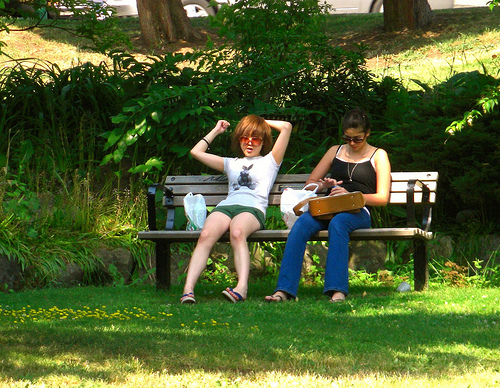

In [ ]:
# Use Image module to check images
Image.open(train_img[0])

In [ ]:
#Assignment 2 starts from here


## Extracting features using pre-trained CNN

Define a `preprocess_input()` function which takes an image array as input and performs the following series of preprocessing steps on it:

  - Divide the image by 255. This normalizes the pixel values to be between 0 and 1.
  - Subtracte 0.5 from the image. This centers the pixel values around 0.
  - Multiply the image by 2. This scales the pixel values to be between -1 and 1.

In [ ]:
def preprocess_input(x):
  x = x/255
  x-=0.5
  x *=2
  return x

In [ ]:
x = image.img_to_array(image.load_img(train_img[0]))
x

array([[[ 30.,  70.,   8.],
        [ 30.,  92.,  17.],
        [ 32.,  67.,   3.],
        ...,
        [ 43., 102.,   8.],
        [ 31.,  75.,   0.],
        [ 34.,  62.,  11.]],

       [[ 30.,  77.,   0.],
        [ 44., 104.,  14.],
        [ 39.,  79.,  17.],
        ...,
        [ 62., 110.,  10.],
        [ 37.,  68.,   0.],
        [ 54.,  79.,  13.]],

       [[ 29.,  93.,   0.],
        [ 41., 109.,  10.],
        [ 47., 106.,  22.],
        ...,
        [138., 171.,  67.],
        [118., 130.,  66.],
        [ 62.,  71.,  14.]],

       ...,

       [[251., 231., 119.],
        [236., 208.,  98.],
        [251., 232., 111.],
        ...,
        [239., 247.,  76.],
        [250., 253., 114.],
        [255., 253., 178.]],

       [[249., 223., 110.],
        [249., 217., 116.],
        [252., 240., 128.],
        ...,
        [250., 250., 150.],
        [254., 253., 147.],
        [252., 253., 159.]],

       [[249., 230., 112.],
        [252., 226., 116.],
        [248., 2

The InceptionV3 model expects input images to have a fixed size of (299, 299).
Define a `preprocess()` function that ensures the input images are resized to this target size.

In [ ]:
def preprocess(image_path):
  img = image.load_img(image_path, target_size=(299, 299))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  return x

In [ ]:
x = preprocess(train_img[0])
x.shape

(1, 299, 299, 3)

In [ ]:
x.squeeze().shape

(299, 299, 3)

(-0.5, 298.5, 298.5, -0.5)

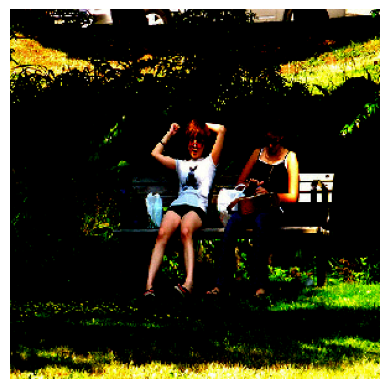

In [ ]:
plt.imshow(np.squeeze(preprocess(train_img[0])))
plt.axis("off")

### Load InceptionV3 model pretrained on imagenet dataset

In [ ]:
model = InceptionV3(weights='imagenet')

96112376/96112376 [==============================] - 5s 0us/step


In [ ]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalizati

We will feed these images to the model to get the encoded images. Hence we need to preprocess the images in the format that the model'll accept. The last layer of InceptionV3 is the softmax classifier which returns the probability of a class. We don't need this layer so we remove it to get the feature representation of the image.

In [ ]:
from keras.models import Model

# taking input layer
new_input = model.input

# taking the 2nd last layer
hidden_layer = model.layers[-2].output

# modifying the existing Inception model to meet our needs
model_new = Model(new_input, hidden_layer)

In [ ]:
model.layers[-2].output

<KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'avg_pool')>

In [ ]:
# Checking
im = model_new.predict(preprocess(train_img[0]))

1/1 [==============================] - 5s 5s/step


In [ ]:
im

array([[1.0696678 , 0.12729028, 0.9257976 , ..., 0.52060056, 0.04053278,
        0.2057839 ]], dtype=float32)

In [ ]:
im.shape

(1, 2048)

Making an encoding function
1. Preprocess the image(use the preprocess() function)
2. apply model_new.predict(img)
3. reshape the output from 2nd step e.g if shape of output is (x,y) then reshape it to (y,), return the output from this

In [ ]:
def encode(image):
  '''
  write here
  '''
  output = model_new.predict(preprocess(image))
  return output.squeeze()

In [ ]:
encode(train_img[0]).shape

1/1 [==============================] - 0s 25ms/step


(2048,)

### Encoding our images
this'll come handy in our data generator part

In [ ]:
encoding_train = {}
for img in tqdm(train_img):
    encoding_train[img[len(images):]] = encode(img) # call the encode function

  0%|          | 0/6000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 2/6000 [00:00<08:22, 11.94it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 4/6000 [00:00<08:13, 12.14it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 6/6000 [00:00<08:08, 12.27it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 8/6000 [00:00<08:57, 11.14it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 10/6000 [00:00<08:50, 11.30it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 12/6000 [00:01<08:44, 11.41it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 14/6000 [00:01<08:30, 11.74it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 16/6000 [00:01<08:27, 11.78it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 18/6000 [00:01<08:29, 11.73it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 20/6000 [00:01<08:34, 11.63it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 22/6000 [00:01<08:27, 11.77it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 24/6000 [00:02<08:59, 11.08it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 26/6000 [00:02<08:45, 11.37it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 28/6000 [00:02<08:46, 11.34it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 30/6000 [00:02<08:35, 11.58it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 32/6000 [00:02<08:33, 11.62it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 34/6000 [00:02<08:33, 11.62it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 36/6000 [00:03<08:38, 11.50it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 38/6000 [00:03<08:30, 11.68it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 40/6000 [00:03<08:26, 11.77it/s]

1/1 [==============================] - 0s 44ms/step


  1%|          | 41/6000 [00:03<08:45, 11.34it/s]


KeyboardInterrupt: 

A pickled file is a file containing a serialized object that can be reconstructed with the pickle module., save the encoding_train as a pickle file, look into `open()`, `pickle.dump()`

In [ ]:
with open("encoded_images_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_train,encoded_pickle)

In [ ]:
encoding_train = pickle.load(open('/content/drive/My Drive/encoded_images_inceptionV3.p', 'rb'))

In [ ]:
# Can check shape of any image, must come out to be (2048,)

Encode test images similarly

In [ ]:
encoding_test = {}
for img in tqdm(test_img):
    encoding_test[img[len(images):]] = encode(img)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 43ms/step


  0%|          | 1/1000 [00:00<02:02,  8.19it/s]

1/1 [==============================] - 0s 54ms/step


  0%|          | 2/1000 [00:00<02:06,  7.87it/s]

1/1 [==============================] - 0s 66ms/step


  0%|          | 3/1000 [00:00<02:16,  7.28it/s]

1/1 [==============================] - 0s 38ms/step


  0%|          | 4/1000 [00:00<02:09,  7.72it/s]

1/1 [==============================] - 0s 38ms/step


  0%|          | 5/1000 [00:00<02:18,  7.21it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 6/1000 [00:00<02:11,  7.53it/s]

1/1 [==============================] - 0s 40ms/step


  1%|          | 7/1000 [00:00<02:10,  7.63it/s]

1/1 [==============================] - 0s 44ms/step


  1%|          | 8/1000 [00:01<02:20,  7.05it/s]

1/1 [==============================] - 0s 42ms/step


  1%|          | 9/1000 [00:01<02:15,  7.33it/s]

1/1 [==============================] - 0s 44ms/step


  1%|          | 10/1000 [00:01<02:11,  7.54it/s]

1/1 [==============================] - 0s 42ms/step


  1%|          | 11/1000 [00:01<02:15,  7.32it/s]

1/1 [==============================] - 0s 59ms/step


  1%|          | 12/1000 [00:01<02:16,  7.24it/s]

1/1 [==============================] - 0s 61ms/step


  1%|▏         | 13/1000 [00:01<02:25,  6.76it/s]

1/1 [==============================] - 0s 51ms/step


  1%|▏         | 14/1000 [00:01<02:23,  6.89it/s]

1/1 [==============================] - 0s 60ms/step


  2%|▏         | 15/1000 [00:02<02:26,  6.74it/s]

1/1 [==============================] - 0s 60ms/step


  2%|▏         | 16/1000 [00:02<02:27,  6.66it/s]

1/1 [==============================] - 0s 74ms/step


  2%|▏         | 17/1000 [00:02<02:35,  6.33it/s]

1/1 [==============================] - 0s 47ms/step


  2%|▏         | 18/1000 [00:02<02:31,  6.48it/s]

1/1 [==============================] - 0s 44ms/step


  2%|▏         | 19/1000 [00:02<02:28,  6.62it/s]

1/1 [==============================] - 0s 60ms/step


  2%|▏         | 20/1000 [00:02<02:27,  6.63it/s]

1/1 [==============================] - 0s 49ms/step


  2%|▏         | 21/1000 [00:03<02:46,  5.89it/s]

1/1 [==============================] - 0s 43ms/step


  2%|▏         | 22/1000 [00:03<02:49,  5.77it/s]

1/1 [==============================] - 0s 82ms/step


  2%|▏         | 23/1000 [00:03<02:54,  5.59it/s]

1/1 [==============================] - 0s 75ms/step


  2%|▏         | 24/1000 [00:03<02:57,  5.50it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▎         | 25/1000 [00:03<02:44,  5.92it/s]

1/1 [==============================] - 0s 83ms/step


  3%|▎         | 26/1000 [00:03<02:50,  5.71it/s]

1/1 [==============================] - 0s 60ms/step


  3%|▎         | 27/1000 [00:04<02:43,  5.94it/s]

1/1 [==============================] - 0s 84ms/step


  3%|▎         | 28/1000 [00:04<02:45,  5.86it/s]

1/1 [==============================] - 0s 48ms/step


  3%|▎         | 29/1000 [00:04<02:38,  6.14it/s]

1/1 [==============================] - 0s 64ms/step


  3%|▎         | 30/1000 [00:04<02:39,  6.07it/s]

1/1 [==============================] - 0s 59ms/step


  3%|▎         | 31/1000 [00:04<02:38,  6.13it/s]

1/1 [==============================] - 0s 50ms/step


  3%|▎         | 32/1000 [00:04<02:39,  6.05it/s]

1/1 [==============================] - 0s 45ms/step


  3%|▎         | 33/1000 [00:05<02:34,  6.26it/s]

1/1 [==============================] - 0s 93ms/step


  3%|▎         | 34/1000 [00:05<02:48,  5.72it/s]

1/1 [==============================] - 0s 75ms/step


  4%|▎         | 35/1000 [00:05<03:05,  5.21it/s]

1/1 [==============================] - 0s 55ms/step


  4%|▎         | 36/1000 [00:05<02:53,  5.57it/s]

1/1 [==============================] - 0s 52ms/step


  4%|▎         | 37/1000 [00:05<02:39,  6.02it/s]

1/1 [==============================] - 0s 85ms/step


  4%|▍         | 38/1000 [00:06<02:48,  5.69it/s]

1/1 [==============================] - 0s 47ms/step


  4%|▍         | 39/1000 [00:06<02:48,  5.70it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▍         | 40/1000 [00:06<02:45,  5.78it/s]

1/1 [==============================] - 0s 49ms/step


  4%|▍         | 41/1000 [00:06<02:40,  5.98it/s]

1/1 [==============================] - 0s 61ms/step


  4%|▍         | 42/1000 [00:06<02:46,  5.77it/s]

1/1 [==============================] - 0s 58ms/step


  4%|▍         | 43/1000 [00:06<02:51,  5.59it/s]

1/1 [==============================] - 0s 69ms/step


  4%|▍         | 44/1000 [00:07<02:52,  5.53it/s]

1/1 [==============================] - 0s 50ms/step


  4%|▍         | 45/1000 [00:07<02:43,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▍         | 46/1000 [00:07<02:32,  6.26it/s]

1/1 [==============================] - 0s 47ms/step


  5%|▍         | 47/1000 [00:07<02:26,  6.52it/s]

1/1 [==============================] - 0s 80ms/step


  5%|▍         | 48/1000 [00:07<02:42,  5.87it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▍         | 49/1000 [00:07<02:34,  6.17it/s]

1/1 [==============================] - 0s 94ms/step


  5%|▌         | 50/1000 [00:08<02:43,  5.79it/s]

1/1 [==============================] - 0s 79ms/step


  5%|▌         | 51/1000 [00:08<02:45,  5.72it/s]

1/1 [==============================] - 0s 68ms/step


  5%|▌         | 52/1000 [00:08<02:45,  5.72it/s]

1/1 [==============================] - 0s 48ms/step


  5%|▌         | 53/1000 [00:08<02:37,  6.03it/s]

1/1 [==============================] - 0s 64ms/step


  5%|▌         | 54/1000 [00:08<02:36,  6.06it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 55/1000 [00:08<02:29,  6.31it/s]

1/1 [==============================] - 0s 65ms/step


  6%|▌         | 56/1000 [00:09<02:30,  6.28it/s]

1/1 [==============================] - 0s 64ms/step


  6%|▌         | 57/1000 [00:09<02:33,  6.14it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 58/1000 [00:09<02:35,  6.05it/s]

1/1 [==============================] - 0s 70ms/step


  6%|▌         | 59/1000 [00:09<02:46,  5.66it/s]

1/1 [==============================] - 0s 49ms/step


  6%|▌         | 60/1000 [00:09<02:44,  5.73it/s]

1/1 [==============================] - 0s 50ms/step


  6%|▌         | 61/1000 [00:09<02:37,  5.98it/s]

1/1 [==============================] - 0s 48ms/step


  6%|▌         | 62/1000 [00:10<02:39,  5.89it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▋         | 63/1000 [00:10<02:26,  6.39it/s]

1/1 [==============================] - 0s 41ms/step


  6%|▋         | 64/1000 [00:10<02:28,  6.30it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▋         | 65/1000 [00:10<02:17,  6.82it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 66/1000 [00:10<02:10,  7.14it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 67/1000 [00:10<02:17,  6.79it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 68/1000 [00:10<02:06,  7.35it/s]

1/1 [==============================] - 0s 42ms/step


  7%|▋         | 69/1000 [00:10<02:05,  7.44it/s]

1/1 [==============================] - 0s 45ms/step


  7%|▋         | 70/1000 [00:11<02:02,  7.60it/s]

1/1 [==============================] - 0s 41ms/step


  7%|▋         | 71/1000 [00:11<01:58,  7.81it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 72/1000 [00:11<01:53,  8.18it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 73/1000 [00:11<01:53,  8.18it/s]

1/1 [==============================] - 0s 57ms/step


  7%|▋         | 74/1000 [00:11<01:57,  7.90it/s]

1/1 [==============================] - 0s 51ms/step


  8%|▊         | 75/1000 [00:11<01:59,  7.71it/s]

1/1 [==============================] - 0s 48ms/step


  8%|▊         | 76/1000 [00:11<02:11,  7.00it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 77/1000 [00:12<02:19,  6.63it/s]

1/1 [==============================] - 0s 42ms/step


  8%|▊         | 78/1000 [00:12<02:13,  6.90it/s]

1/1 [==============================] - 0s 42ms/step


  8%|▊         | 79/1000 [00:12<02:07,  7.22it/s]

1/1 [==============================] - 0s 45ms/step


  8%|▊         | 80/1000 [00:12<02:15,  6.77it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 81/1000 [00:12<02:08,  7.15it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 82/1000 [00:12<02:02,  7.47it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 83/1000 [00:12<02:07,  7.17it/s]

1/1 [==============================] - 0s 49ms/step


  8%|▊         | 84/1000 [00:13<02:06,  7.25it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 85/1000 [00:13<02:14,  6.79it/s]

1/1 [==============================] - 0s 42ms/step


  9%|▊         | 86/1000 [00:13<02:09,  7.04it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▊         | 87/1000 [00:13<02:05,  7.25it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▉         | 88/1000 [00:13<01:59,  7.65it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 89/1000 [00:13<01:55,  7.87it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 90/1000 [00:13<02:04,  7.33it/s]

1/1 [==============================] - 0s 44ms/step


  9%|▉         | 91/1000 [00:13<01:58,  7.68it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 92/1000 [00:14<02:11,  6.90it/s]

1/1 [==============================] - 0s 53ms/step


  9%|▉         | 93/1000 [00:14<02:07,  7.13it/s]

1/1 [==============================] - 0s 46ms/step


  9%|▉         | 94/1000 [00:14<02:14,  6.72it/s]

1/1 [==============================] - 0s 37ms/step


 10%|▉         | 95/1000 [00:14<02:07,  7.11it/s]

1/1 [==============================] - 0s 44ms/step


 10%|▉         | 96/1000 [00:14<02:04,  7.24it/s]

1/1 [==============================] - 0s 39ms/step


 10%|▉         | 97/1000 [00:14<01:57,  7.68it/s]

1/1 [==============================] - 0s 40ms/step


 10%|▉         | 98/1000 [00:14<01:52,  8.01it/s]

1/1 [==============================] - 0s 38ms/step


 10%|▉         | 99/1000 [00:15<02:01,  7.42it/s]

1/1 [==============================] - 0s 52ms/step


 10%|█         | 100/1000 [00:15<02:02,  7.36it/s]

1/1 [==============================] - 0s 40ms/step


 10%|█         | 101/1000 [00:15<01:58,  7.59it/s]

1/1 [==============================] - 0s 43ms/step


 10%|█         | 102/1000 [00:15<02:13,  6.73it/s]

1/1 [==============================] - 0s 39ms/step


 10%|█         | 103/1000 [00:15<02:20,  6.38it/s]

1/1 [==============================] - 0s 37ms/step


 10%|█         | 104/1000 [00:15<02:18,  6.45it/s]

1/1 [==============================] - 0s 50ms/step


 10%|█         | 105/1000 [00:15<02:10,  6.88it/s]

1/1 [==============================] - 0s 47ms/step


 11%|█         | 106/1000 [00:16<02:04,  7.16it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 107/1000 [00:16<01:58,  7.54it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█         | 108/1000 [00:16<01:54,  7.79it/s]

1/1 [==============================] - 0s 43ms/step


 11%|█         | 109/1000 [00:16<01:53,  7.85it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 110/1000 [00:16<02:04,  7.18it/s]

1/1 [==============================] - 0s 47ms/step


 11%|█         | 111/1000 [00:16<01:59,  7.43it/s]

1/1 [==============================] - 0s 42ms/step


 11%|█         | 112/1000 [00:16<01:57,  7.53it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█▏        | 113/1000 [00:16<01:54,  7.75it/s]

1/1 [==============================] - 0s 47ms/step


 11%|█▏        | 114/1000 [00:17<01:53,  7.78it/s]

1/1 [==============================] - 0s 46ms/step


 12%|█▏        | 115/1000 [00:17<01:51,  7.93it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 116/1000 [00:17<01:51,  7.91it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 117/1000 [00:17<02:02,  7.24it/s]

1/1 [==============================] - 0s 46ms/step


 12%|█▏        | 118/1000 [00:17<01:59,  7.39it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 119/1000 [00:17<01:53,  7.75it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 120/1000 [00:17<01:48,  8.11it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▏        | 121/1000 [00:18<01:54,  7.70it/s]

1/1 [==============================] - 0s 67ms/step


 12%|█▏        | 122/1000 [00:18<01:58,  7.44it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 123/1000 [00:18<01:55,  7.63it/s]

1/1 [==============================] - 0s 44ms/step


 12%|█▏        | 124/1000 [00:18<01:54,  7.67it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▎        | 125/1000 [00:18<01:52,  7.78it/s]

1/1 [==============================] - 0s 41ms/step


 13%|█▎        | 126/1000 [00:18<01:50,  7.88it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 127/1000 [00:18<01:48,  8.05it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 128/1000 [00:18<01:45,  8.26it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 129/1000 [00:19<01:53,  7.64it/s]

1/1 [==============================] - 0s 51ms/step


 13%|█▎        | 130/1000 [00:19<01:55,  7.50it/s]

1/1 [==============================] - 0s 57ms/step


 13%|█▎        | 131/1000 [00:19<02:04,  6.97it/s]

1/1 [==============================] - 0s 49ms/step


 13%|█▎        | 132/1000 [00:19<02:00,  7.20it/s]

1/1 [==============================] - 0s 51ms/step


 13%|█▎        | 133/1000 [00:19<01:56,  7.43it/s]

1/1 [==============================] - 0s 41ms/step


 13%|█▎        | 134/1000 [00:19<01:51,  7.77it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▎        | 135/1000 [00:19<01:52,  7.69it/s]

1/1 [==============================] - 0s 48ms/step


 14%|█▎        | 136/1000 [00:20<01:55,  7.51it/s]

1/1 [==============================] - 0s 65ms/step


 14%|█▎        | 137/1000 [00:20<01:59,  7.24it/s]

1/1 [==============================] - 0s 61ms/step


 14%|█▍        | 138/1000 [00:20<02:05,  6.88it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▍        | 139/1000 [00:20<02:08,  6.68it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 140/1000 [00:20<02:01,  7.10it/s]

1/1 [==============================] - 0s 52ms/step


 14%|█▍        | 141/1000 [00:20<01:57,  7.29it/s]

1/1 [==============================] - 0s 44ms/step


 14%|█▍        | 142/1000 [00:20<01:56,  7.39it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▍        | 143/1000 [00:20<01:54,  7.50it/s]

1/1 [==============================] - 0s 72ms/step


 14%|█▍        | 144/1000 [00:21<02:05,  6.82it/s]

1/1 [==============================] - 0s 64ms/step


 14%|█▍        | 145/1000 [00:21<02:10,  6.58it/s]

1/1 [==============================] - 0s 64ms/step


 15%|█▍        | 146/1000 [00:21<02:15,  6.32it/s]

1/1 [==============================] - 0s 47ms/step


 15%|█▍        | 147/1000 [00:21<02:13,  6.41it/s]

1/1 [==============================] - 0s 45ms/step


 15%|█▍        | 148/1000 [00:21<02:16,  6.24it/s]

1/1 [==============================] - 0s 48ms/step


 15%|█▍        | 149/1000 [00:21<02:15,  6.28it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▌        | 150/1000 [00:22<02:07,  6.66it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▌        | 151/1000 [00:22<02:03,  6.85it/s]

1/1 [==============================] - 0s 43ms/step


 15%|█▌        | 152/1000 [00:22<02:11,  6.44it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█▌        | 153/1000 [00:22<02:06,  6.68it/s]

1/1 [==============================] - 0s 43ms/step


 15%|█▌        | 154/1000 [00:22<02:00,  7.01it/s]

1/1 [==============================] - 0s 79ms/step


 16%|█▌        | 155/1000 [00:22<02:07,  6.61it/s]

1/1 [==============================] - 0s 53ms/step


 16%|█▌        | 156/1000 [00:23<02:05,  6.73it/s]

1/1 [==============================] - 0s 44ms/step


 16%|█▌        | 157/1000 [00:23<02:14,  6.28it/s]

1/1 [==============================] - 0s 53ms/step


 16%|█▌        | 158/1000 [00:23<02:11,  6.39it/s]

1/1 [==============================] - 0s 44ms/step


 16%|█▌        | 159/1000 [00:23<02:10,  6.47it/s]

1/1 [==============================] - 0s 54ms/step


 16%|█▌        | 160/1000 [00:23<02:04,  6.75it/s]

1/1 [==============================] - 0s 55ms/step


 16%|█▌        | 161/1000 [00:23<02:03,  6.79it/s]

1/1 [==============================] - 0s 42ms/step


 16%|█▌        | 162/1000 [00:23<02:01,  6.89it/s]

1/1 [==============================] - 0s 64ms/step


 16%|█▋        | 163/1000 [00:24<02:03,  6.76it/s]

1/1 [==============================] - 0s 46ms/step


 16%|█▋        | 164/1000 [00:24<01:59,  6.98it/s]

1/1 [==============================] - 0s 42ms/step


 16%|█▋        | 165/1000 [00:24<02:02,  6.84it/s]

1/1 [==============================] - 0s 68ms/step


 17%|█▋        | 166/1000 [00:24<02:05,  6.65it/s]

1/1 [==============================] - 0s 59ms/step


 17%|█▋        | 167/1000 [00:24<02:10,  6.40it/s]

1/1 [==============================] - 0s 45ms/step


 17%|█▋        | 168/1000 [00:24<02:07,  6.55it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 169/1000 [00:24<02:10,  6.37it/s]

1/1 [==============================] - 0s 81ms/step


 17%|█▋        | 170/1000 [00:25<02:16,  6.09it/s]

1/1 [==============================] - 0s 42ms/step


 17%|█▋        | 171/1000 [00:25<02:06,  6.56it/s]

1/1 [==============================] - 0s 76ms/step


 17%|█▋        | 172/1000 [00:25<02:10,  6.34it/s]

1/1 [==============================] - 0s 53ms/step


 17%|█▋        | 173/1000 [00:25<02:09,  6.39it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 174/1000 [00:25<02:08,  6.41it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 175/1000 [00:25<02:09,  6.35it/s]

1/1 [==============================] - 0s 64ms/step


 18%|█▊        | 176/1000 [00:26<02:19,  5.90it/s]

1/1 [==============================] - 0s 62ms/step


 18%|█▊        | 177/1000 [00:26<02:16,  6.01it/s]

1/1 [==============================] - 0s 54ms/step


 18%|█▊        | 178/1000 [00:26<02:11,  6.25it/s]

1/1 [==============================] - 0s 66ms/step


 18%|█▊        | 179/1000 [00:26<02:11,  6.26it/s]

1/1 [==============================] - 0s 56ms/step


 18%|█▊        | 180/1000 [00:26<02:10,  6.30it/s]

1/1 [==============================] - 0s 52ms/step


 18%|█▊        | 181/1000 [00:26<02:06,  6.48it/s]

1/1 [==============================] - 0s 60ms/step


 18%|█▊        | 182/1000 [00:27<02:06,  6.48it/s]

1/1 [==============================] - 0s 41ms/step


 18%|█▊        | 183/1000 [00:27<02:00,  6.80it/s]

1/1 [==============================] - 0s 69ms/step


 18%|█▊        | 184/1000 [00:27<02:05,  6.48it/s]

1/1 [==============================] - 0s 65ms/step


 18%|█▊        | 185/1000 [00:27<02:15,  6.02it/s]

1/1 [==============================] - 0s 59ms/step


 19%|█▊        | 186/1000 [00:27<02:19,  5.84it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▊        | 187/1000 [00:27<02:05,  6.46it/s]

1/1 [==============================] - 0s 38ms/step


 19%|█▉        | 188/1000 [00:28<02:08,  6.33it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▉        | 189/1000 [00:28<01:56,  6.94it/s]

1/1 [==============================] - 0s 41ms/step


 19%|█▉        | 190/1000 [00:28<01:53,  7.11it/s]

1/1 [==============================] - 0s 41ms/step


 19%|█▉        | 191/1000 [00:28<01:47,  7.50it/s]

1/1 [==============================] - 0s 51ms/step


 19%|█▉        | 192/1000 [00:28<01:53,  7.09it/s]

1/1 [==============================] - 0s 53ms/step


 19%|█▉        | 193/1000 [00:28<02:00,  6.68it/s]

1/1 [==============================] - 0s 40ms/step


 19%|█▉        | 194/1000 [00:28<01:57,  6.86it/s]

1/1 [==============================] - 0s 51ms/step


 20%|█▉        | 195/1000 [00:28<01:52,  7.16it/s]

1/1 [==============================] - 0s 38ms/step


 20%|█▉        | 196/1000 [00:29<01:48,  7.40it/s]

1/1 [==============================] - 0s 39ms/step


 20%|█▉        | 197/1000 [00:29<01:43,  7.74it/s]

1/1 [==============================] - 0s 36ms/step


 20%|█▉        | 198/1000 [00:29<01:40,  7.98it/s]

1/1 [==============================] - 0s 40ms/step


 20%|█▉        | 199/1000 [00:29<01:39,  8.06it/s]

1/1 [==============================] - 0s 39ms/step


 20%|██        | 200/1000 [00:29<01:41,  7.90it/s]

1/1 [==============================] - 0s 38ms/step


 20%|██        | 201/1000 [00:29<01:51,  7.17it/s]

1/1 [==============================] - 0s 39ms/step


 20%|██        | 202/1000 [00:29<01:59,  6.68it/s]

1/1 [==============================] - 0s 43ms/step


 20%|██        | 203/1000 [00:30<01:55,  6.88it/s]

1/1 [==============================] - 0s 37ms/step


 20%|██        | 204/1000 [00:30<01:48,  7.32it/s]

1/1 [==============================] - 0s 39ms/step


 20%|██        | 205/1000 [00:30<01:52,  7.06it/s]

1/1 [==============================] - 0s 45ms/step


 21%|██        | 206/1000 [00:30<01:59,  6.64it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██        | 207/1000 [00:30<02:05,  6.34it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██        | 208/1000 [00:30<01:55,  6.87it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██        | 209/1000 [00:30<01:59,  6.64it/s]

1/1 [==============================] - 0s 42ms/step


 21%|██        | 210/1000 [00:31<02:02,  6.45it/s]

1/1 [==============================] - 0s 42ms/step


 21%|██        | 211/1000 [00:31<01:56,  6.79it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 212/1000 [00:31<01:58,  6.67it/s]

1/1 [==============================] - 0s 42ms/step


 21%|██▏       | 213/1000 [00:31<02:03,  6.36it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██▏       | 214/1000 [00:31<01:55,  6.80it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 215/1000 [00:31<01:57,  6.67it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 216/1000 [00:31<01:52,  6.97it/s]

1/1 [==============================] - 0s 60ms/step


 22%|██▏       | 217/1000 [00:32<01:56,  6.73it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██▏       | 218/1000 [00:32<01:59,  6.53it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██▏       | 219/1000 [00:32<01:59,  6.51it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 220/1000 [00:32<02:00,  6.48it/s]

1/1 [==============================] - 0s 41ms/step


 22%|██▏       | 221/1000 [00:32<01:51,  6.96it/s]

1/1 [==============================] - 0s 52ms/step


 22%|██▏       | 222/1000 [00:32<01:51,  7.00it/s]

1/1 [==============================] - 0s 46ms/step


 22%|██▏       | 223/1000 [00:33<01:48,  7.19it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 224/1000 [00:33<01:43,  7.52it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▎       | 225/1000 [00:33<01:42,  7.57it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 226/1000 [00:33<01:38,  7.83it/s]

1/1 [==============================] - 0s 44ms/step


 23%|██▎       | 227/1000 [00:33<01:48,  7.11it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 228/1000 [00:33<01:53,  6.78it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 229/1000 [00:33<01:45,  7.30it/s]

1/1 [==============================] - 0s 43ms/step


 23%|██▎       | 230/1000 [00:33<01:41,  7.62it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 231/1000 [00:34<01:49,  7.04it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 232/1000 [00:34<01:52,  6.85it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 233/1000 [00:34<01:48,  7.08it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 234/1000 [00:34<01:41,  7.52it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▎       | 235/1000 [00:34<01:37,  7.89it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▎       | 236/1000 [00:34<01:33,  8.16it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▎       | 237/1000 [00:34<01:30,  8.40it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 238/1000 [00:34<01:31,  8.34it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 239/1000 [00:35<01:35,  7.97it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▍       | 240/1000 [00:35<01:35,  7.96it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▍       | 241/1000 [00:35<01:32,  8.21it/s]

1/1 [==============================] - 0s 42ms/step


 24%|██▍       | 242/1000 [00:35<01:31,  8.26it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 243/1000 [00:35<01:31,  8.24it/s]

1/1 [==============================] - 0s 43ms/step


 24%|██▍       | 244/1000 [00:35<01:39,  7.61it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▍       | 245/1000 [00:35<01:46,  7.09it/s]

1/1 [==============================] - 0s 46ms/step


 25%|██▍       | 246/1000 [00:36<01:43,  7.29it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▍       | 247/1000 [00:36<01:40,  7.53it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▍       | 248/1000 [00:36<01:35,  7.88it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▍       | 249/1000 [00:36<01:35,  7.85it/s]

1/1 [==============================] - 0s 41ms/step


 25%|██▌       | 250/1000 [00:36<01:34,  7.89it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▌       | 251/1000 [00:36<01:31,  8.14it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▌       | 252/1000 [00:36<01:31,  8.19it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▌       | 253/1000 [00:36<01:29,  8.30it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▌       | 254/1000 [00:36<01:28,  8.41it/s]

1/1 [==============================] - 0s 63ms/step


 26%|██▌       | 255/1000 [00:37<01:33,  7.94it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 256/1000 [00:37<01:32,  8.06it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▌       | 257/1000 [00:37<01:31,  8.14it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██▌       | 258/1000 [00:37<01:44,  7.10it/s]

1/1 [==============================] - 0s 46ms/step


 26%|██▌       | 259/1000 [00:37<01:49,  6.75it/s]

1/1 [==============================] - 0s 53ms/step


 26%|██▌       | 260/1000 [00:37<01:51,  6.62it/s]

1/1 [==============================] - 0s 86ms/step


 26%|██▌       | 261/1000 [00:38<01:55,  6.43it/s]

1/1 [==============================] - 0s 59ms/step


 26%|██▌       | 262/1000 [00:38<01:58,  6.23it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██▋       | 263/1000 [00:38<01:57,  6.26it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██▋       | 264/1000 [00:38<01:59,  6.18it/s]

1/1 [==============================] - 0s 47ms/step


 26%|██▋       | 265/1000 [00:38<01:56,  6.33it/s]

1/1 [==============================] - 0s 80ms/step


 27%|██▋       | 266/1000 [00:38<02:09,  5.65it/s]

1/1 [==============================] - 0s 52ms/step


 27%|██▋       | 267/1000 [00:39<02:04,  5.89it/s]

1/1 [==============================] - 0s 50ms/step


 27%|██▋       | 268/1000 [00:39<01:58,  6.17it/s]

1/1 [==============================] - 0s 79ms/step


 27%|██▋       | 269/1000 [00:39<02:00,  6.05it/s]

1/1 [==============================] - 0s 58ms/step


 27%|██▋       | 270/1000 [00:39<01:59,  6.09it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 271/1000 [00:39<02:00,  6.04it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 272/1000 [00:39<02:01,  6.00it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 273/1000 [00:40<01:56,  6.24it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██▋       | 274/1000 [00:40<01:48,  6.66it/s]

1/1 [==============================] - 0s 61ms/step


 28%|██▊       | 275/1000 [00:40<01:48,  6.69it/s]

1/1 [==============================] - 0s 44ms/step


 28%|██▊       | 276/1000 [00:40<01:52,  6.42it/s]

1/1 [==============================] - 0s 54ms/step


 28%|██▊       | 277/1000 [00:40<01:54,  6.31it/s]

1/1 [==============================] - 0s 49ms/step


 28%|██▊       | 278/1000 [00:40<01:54,  6.29it/s]

1/1 [==============================] - 0s 50ms/step


 28%|██▊       | 279/1000 [00:40<01:52,  6.44it/s]

1/1 [==============================] - 0s 67ms/step


 28%|██▊       | 280/1000 [00:41<02:01,  5.91it/s]

1/1 [==============================] - 0s 69ms/step


 28%|██▊       | 281/1000 [00:41<02:04,  5.76it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 282/1000 [00:41<01:57,  6.11it/s]

1/1 [==============================] - 0s 43ms/step


 28%|██▊       | 283/1000 [00:41<01:49,  6.54it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 284/1000 [00:41<01:43,  6.89it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 285/1000 [00:41<01:38,  7.25it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▊       | 286/1000 [00:41<01:39,  7.19it/s]

1/1 [==============================] - 0s 42ms/step


 29%|██▊       | 287/1000 [00:42<01:38,  7.25it/s]

1/1 [==============================] - 0s 58ms/step


 29%|██▉       | 288/1000 [00:42<01:39,  7.12it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 289/1000 [00:42<01:37,  7.30it/s]

1/1 [==============================] - 0s 49ms/step


 29%|██▉       | 290/1000 [00:42<01:38,  7.21it/s]

1/1 [==============================] - 0s 44ms/step


 29%|██▉       | 291/1000 [00:42<01:40,  7.04it/s]

1/1 [==============================] - 0s 80ms/step


 29%|██▉       | 292/1000 [00:42<01:50,  6.39it/s]

1/1 [==============================] - 0s 55ms/step


 29%|██▉       | 293/1000 [00:43<01:51,  6.33it/s]

1/1 [==============================] - 0s 41ms/step


 29%|██▉       | 294/1000 [00:43<01:53,  6.22it/s]

1/1 [==============================] - 0s 43ms/step


 30%|██▉       | 295/1000 [00:43<01:50,  6.39it/s]

1/1 [==============================] - 0s 79ms/step


 30%|██▉       | 296/1000 [00:43<01:56,  6.05it/s]

1/1 [==============================] - 0s 55ms/step


 30%|██▉       | 297/1000 [00:43<01:50,  6.37it/s]

1/1 [==============================] - 0s 51ms/step


 30%|██▉       | 298/1000 [00:43<01:49,  6.41it/s]

1/1 [==============================] - 0s 42ms/step


 30%|██▉       | 299/1000 [00:43<01:48,  6.46it/s]

1/1 [==============================] - 0s 51ms/step


 30%|███       | 300/1000 [00:44<01:47,  6.49it/s]

1/1 [==============================] - 0s 76ms/step


 30%|███       | 301/1000 [00:44<01:58,  5.91it/s]

1/1 [==============================] - 0s 75ms/step


 30%|███       | 302/1000 [00:44<02:02,  5.70it/s]

1/1 [==============================] - 0s 36ms/step


 30%|███       | 303/1000 [00:44<01:51,  6.23it/s]

1/1 [==============================] - 0s 47ms/step


 30%|███       | 304/1000 [00:44<01:47,  6.45it/s]

1/1 [==============================] - 0s 41ms/step


 30%|███       | 305/1000 [00:44<01:44,  6.68it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 306/1000 [00:45<01:41,  6.85it/s]

1/1 [==============================] - 0s 79ms/step


 31%|███       | 307/1000 [00:45<01:47,  6.45it/s]

1/1 [==============================] - 0s 45ms/step


 31%|███       | 308/1000 [00:45<01:45,  6.54it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 309/1000 [00:45<01:40,  6.90it/s]

1/1 [==============================] - 0s 50ms/step


 31%|███       | 310/1000 [00:45<01:35,  7.22it/s]

1/1 [==============================] - 0s 48ms/step


 31%|███       | 311/1000 [00:45<01:32,  7.48it/s]

1/1 [==============================] - 0s 46ms/step


 31%|███       | 312/1000 [00:45<01:28,  7.80it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███▏      | 313/1000 [00:45<01:26,  7.92it/s]

1/1 [==============================] - 0s 46ms/step


 31%|███▏      | 314/1000 [00:46<01:28,  7.74it/s]

1/1 [==============================] - 0s 42ms/step


 32%|███▏      | 315/1000 [00:46<01:26,  7.91it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 316/1000 [00:46<01:34,  7.22it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 317/1000 [00:46<01:30,  7.54it/s]

1/1 [==============================] - 0s 49ms/step


 32%|███▏      | 318/1000 [00:46<01:31,  7.45it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 319/1000 [00:46<01:35,  7.16it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 320/1000 [00:46<01:30,  7.51it/s]

1/1 [==============================] - 0s 53ms/step


 32%|███▏      | 321/1000 [00:47<01:35,  7.08it/s]

1/1 [==============================] - 0s 46ms/step


 32%|███▏      | 322/1000 [00:47<01:32,  7.29it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 323/1000 [00:47<01:38,  6.86it/s]

1/1 [==============================] - 0s 47ms/step


 32%|███▏      | 324/1000 [00:47<01:34,  7.16it/s]

1/1 [==============================] - 0s 43ms/step


 32%|███▎      | 325/1000 [00:47<01:32,  7.28it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 326/1000 [00:47<01:29,  7.53it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 327/1000 [00:47<01:32,  7.24it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 328/1000 [00:48<01:28,  7.61it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 329/1000 [00:48<01:33,  7.20it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 330/1000 [00:48<01:28,  7.55it/s]

1/1 [==============================] - 0s 55ms/step


 33%|███▎      | 331/1000 [00:48<01:35,  7.01it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 332/1000 [00:48<01:40,  6.62it/s]

1/1 [==============================] - 0s 47ms/step


 33%|███▎      | 333/1000 [00:48<01:39,  6.73it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 334/1000 [00:48<01:32,  7.20it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▎      | 335/1000 [00:49<01:27,  7.57it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▎      | 336/1000 [00:49<01:24,  7.81it/s]

1/1 [==============================] - 0s 46ms/step


 34%|███▎      | 337/1000 [00:49<01:24,  7.85it/s]

1/1 [==============================] - 0s 45ms/step


 34%|███▍      | 338/1000 [00:49<01:25,  7.78it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▍      | 339/1000 [00:49<01:22,  8.05it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▍      | 340/1000 [00:49<01:28,  7.42it/s]

1/1 [==============================] - 0s 54ms/step


 34%|███▍      | 341/1000 [00:49<01:29,  7.39it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▍      | 342/1000 [00:49<01:35,  6.89it/s]

1/1 [==============================] - 0s 45ms/step


 34%|███▍      | 343/1000 [00:50<01:32,  7.07it/s]

1/1 [==============================] - 0s 60ms/step


 34%|███▍      | 344/1000 [00:50<01:35,  6.86it/s]

1/1 [==============================] - 0s 44ms/step


 34%|███▍      | 345/1000 [00:50<01:38,  6.62it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▍      | 346/1000 [00:50<01:39,  6.58it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▍      | 347/1000 [00:50<01:40,  6.48it/s]

1/1 [==============================] - 0s 59ms/step


 35%|███▍      | 348/1000 [00:50<01:38,  6.65it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▍      | 349/1000 [00:51<01:31,  7.08it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▌      | 350/1000 [00:51<01:40,  6.49it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▌      | 351/1000 [00:51<01:35,  6.79it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▌      | 352/1000 [00:51<01:30,  7.13it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▌      | 353/1000 [00:51<01:28,  7.28it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▌      | 354/1000 [00:51<01:28,  7.33it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 355/1000 [00:51<01:24,  7.66it/s]

1/1 [==============================] - 0s 53ms/step


 36%|███▌      | 356/1000 [00:51<01:24,  7.61it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 357/1000 [00:52<01:28,  7.25it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 358/1000 [00:52<01:23,  7.71it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 359/1000 [00:52<01:23,  7.64it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 360/1000 [00:52<01:22,  7.80it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 361/1000 [00:52<01:19,  8.04it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 362/1000 [00:52<01:17,  8.19it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▋      | 363/1000 [00:52<01:17,  8.21it/s]

1/1 [==============================] - 0s 56ms/step


 36%|███▋      | 364/1000 [00:52<01:19,  8.02it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▋      | 365/1000 [00:53<01:17,  8.24it/s]

1/1 [==============================] - 0s 44ms/step


 37%|███▋      | 366/1000 [00:53<01:19,  7.95it/s]

1/1 [==============================] - 0s 45ms/step


 37%|███▋      | 367/1000 [00:53<01:17,  8.12it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 368/1000 [00:53<01:17,  8.14it/s]

1/1 [==============================] - 0s 54ms/step


 37%|███▋      | 369/1000 [00:53<01:20,  7.83it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 370/1000 [00:53<01:18,  8.02it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 371/1000 [00:53<01:15,  8.28it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 372/1000 [00:53<01:15,  8.29it/s]

1/1 [==============================] - 0s 49ms/step


 37%|███▋      | 373/1000 [00:54<01:23,  7.50it/s]

1/1 [==============================] - 0s 43ms/step


 37%|███▋      | 374/1000 [00:54<01:21,  7.66it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 375/1000 [00:54<01:28,  7.08it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 376/1000 [00:54<01:34,  6.60it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 377/1000 [00:54<01:36,  6.48it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 378/1000 [00:54<01:37,  6.39it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 379/1000 [00:55<01:30,  6.86it/s]

1/1 [==============================] - 0s 46ms/step


 38%|███▊      | 380/1000 [00:55<01:29,  6.96it/s]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 381/1000 [00:55<01:27,  7.09it/s]

1/1 [==============================] - 0s 45ms/step


 38%|███▊      | 382/1000 [00:55<01:24,  7.32it/s]

1/1 [==============================] - 0s 63ms/step


 38%|███▊      | 383/1000 [00:55<01:28,  6.99it/s]

1/1 [==============================] - 0s 62ms/step


 38%|███▊      | 384/1000 [00:55<01:29,  6.85it/s]

1/1 [==============================] - 0s 53ms/step


 38%|███▊      | 385/1000 [00:55<01:33,  6.56it/s]

1/1 [==============================] - 0s 45ms/step


 39%|███▊      | 386/1000 [00:56<01:29,  6.87it/s]

1/1 [==============================] - 0s 59ms/step


 39%|███▊      | 387/1000 [00:56<01:32,  6.63it/s]

1/1 [==============================] - 0s 48ms/step


 39%|███▉      | 388/1000 [00:56<01:31,  6.70it/s]

1/1 [==============================] - 0s 53ms/step


 39%|███▉      | 389/1000 [00:56<01:31,  6.66it/s]

1/1 [==============================] - 0s 78ms/step


 39%|███▉      | 390/1000 [00:56<01:34,  6.43it/s]

1/1 [==============================] - 0s 73ms/step


 39%|███▉      | 391/1000 [00:56<01:38,  6.20it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 392/1000 [00:56<01:31,  6.63it/s]

1/1 [==============================] - 0s 52ms/step


 39%|███▉      | 393/1000 [00:57<01:28,  6.84it/s]

1/1 [==============================] - 0s 56ms/step


 39%|███▉      | 394/1000 [00:57<01:28,  6.83it/s]

1/1 [==============================] - 0s 39ms/step


 40%|███▉      | 395/1000 [00:57<01:24,  7.18it/s]

1/1 [==============================] - 0s 39ms/step


 40%|███▉      | 396/1000 [00:57<01:26,  6.97it/s]

1/1 [==============================] - 0s 44ms/step


 40%|███▉      | 397/1000 [00:57<01:24,  7.13it/s]

1/1 [==============================] - 0s 40ms/step


 40%|███▉      | 398/1000 [00:57<01:22,  7.31it/s]

1/1 [==============================] - 0s 58ms/step


 40%|███▉      | 399/1000 [00:57<01:25,  7.00it/s]

1/1 [==============================] - 0s 57ms/step


 40%|████      | 400/1000 [00:58<01:27,  6.89it/s]

1/1 [==============================] - 0s 59ms/step


 40%|████      | 401/1000 [00:58<01:35,  6.28it/s]

1/1 [==============================] - 0s 40ms/step


 40%|████      | 402/1000 [00:58<01:36,  6.22it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████      | 403/1000 [00:58<01:38,  6.07it/s]

1/1 [==============================] - 0s 79ms/step


 40%|████      | 404/1000 [00:58<01:37,  6.10it/s]

1/1 [==============================] - 0s 34ms/step


 40%|████      | 405/1000 [00:58<01:35,  6.20it/s]

1/1 [==============================] - 0s 53ms/step


 41%|████      | 406/1000 [00:59<01:35,  6.24it/s]

1/1 [==============================] - 0s 81ms/step


 41%|████      | 407/1000 [00:59<01:39,  5.94it/s]

1/1 [==============================] - 0s 44ms/step


 41%|████      | 408/1000 [00:59<01:35,  6.19it/s]

1/1 [==============================] - 0s 60ms/step


 41%|████      | 409/1000 [00:59<01:34,  6.26it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████      | 410/1000 [00:59<01:30,  6.55it/s]

1/1 [==============================] - 0s 50ms/step


 41%|████      | 411/1000 [00:59<01:28,  6.67it/s]

1/1 [==============================] - 0s 70ms/step


 41%|████      | 412/1000 [01:00<01:32,  6.35it/s]

1/1 [==============================] - 0s 58ms/step


 41%|████▏     | 413/1000 [01:00<01:30,  6.47it/s]

1/1 [==============================] - 0s 55ms/step


 41%|████▏     | 414/1000 [01:00<01:39,  5.92it/s]

1/1 [==============================] - 0s 64ms/step


 42%|████▏     | 415/1000 [01:00<01:36,  6.08it/s]

1/1 [==============================] - 0s 51ms/step


 42%|████▏     | 416/1000 [01:00<01:35,  6.12it/s]

1/1 [==============================] - 0s 72ms/step


 42%|████▏     | 417/1000 [01:00<01:37,  5.96it/s]

1/1 [==============================] - 0s 61ms/step


 42%|████▏     | 418/1000 [01:01<01:38,  5.93it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 419/1000 [01:01<01:29,  6.46it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████▏     | 420/1000 [01:01<01:25,  6.75it/s]

1/1 [==============================] - 0s 59ms/step


 42%|████▏     | 421/1000 [01:01<01:25,  6.74it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 422/1000 [01:01<01:23,  6.93it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 423/1000 [01:01<01:23,  6.91it/s]

1/1 [==============================] - 0s 60ms/step


 42%|████▏     | 424/1000 [01:01<01:35,  6.03it/s]

1/1 [==============================] - 0s 44ms/step


 42%|████▎     | 425/1000 [01:02<01:35,  6.00it/s]

1/1 [==============================] - 0s 55ms/step


 43%|████▎     | 426/1000 [01:02<01:36,  5.97it/s]

1/1 [==============================] - 0s 73ms/step


 43%|████▎     | 427/1000 [01:02<01:38,  5.83it/s]

1/1 [==============================] - 0s 59ms/step


 43%|████▎     | 428/1000 [01:02<01:35,  6.01it/s]

1/1 [==============================] - 0s 53ms/step


 43%|████▎     | 429/1000 [01:02<01:34,  6.03it/s]

1/1 [==============================] - 0s 47ms/step


 43%|████▎     | 430/1000 [01:02<01:29,  6.34it/s]

1/1 [==============================] - 0s 42ms/step


 43%|████▎     | 431/1000 [01:03<01:26,  6.57it/s]

1/1 [==============================] - 0s 45ms/step


 43%|████▎     | 432/1000 [01:03<01:27,  6.49it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 433/1000 [01:03<01:28,  6.38it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 434/1000 [01:03<01:28,  6.36it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▎     | 435/1000 [01:03<01:21,  6.91it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▎     | 436/1000 [01:03<01:22,  6.81it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▎     | 437/1000 [01:03<01:24,  6.68it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▍     | 438/1000 [01:04<01:20,  7.00it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 439/1000 [01:04<01:22,  6.80it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 440/1000 [01:04<01:20,  6.99it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 441/1000 [01:04<01:15,  7.40it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 442/1000 [01:04<01:15,  7.35it/s]

1/1 [==============================] - 0s 44ms/step


 44%|████▍     | 443/1000 [01:04<01:14,  7.45it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 444/1000 [01:04<01:11,  7.81it/s]

1/1 [==============================] - 0s 45ms/step


 44%|████▍     | 445/1000 [01:05<01:09,  8.04it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▍     | 446/1000 [01:05<01:07,  8.16it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▍     | 447/1000 [01:05<01:13,  7.52it/s]

1/1 [==============================] - 0s 43ms/step


 45%|████▍     | 448/1000 [01:05<01:11,  7.70it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▍     | 449/1000 [01:05<01:09,  7.94it/s]

1/1 [==============================] - 0s 52ms/step


 45%|████▌     | 450/1000 [01:05<01:12,  7.58it/s]

1/1 [==============================] - 0s 43ms/step


 45%|████▌     | 451/1000 [01:05<01:19,  6.95it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▌     | 452/1000 [01:05<01:15,  7.29it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▌     | 453/1000 [01:06<01:17,  7.02it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▌     | 454/1000 [01:06<01:17,  7.08it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 455/1000 [01:06<01:19,  6.84it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 456/1000 [01:06<01:14,  7.32it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 457/1000 [01:06<01:17,  7.04it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 458/1000 [01:06<01:13,  7.41it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 459/1000 [01:06<01:17,  7.00it/s]

1/1 [==============================] - 0s 44ms/step


 46%|████▌     | 460/1000 [01:07<01:16,  7.07it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 461/1000 [01:07<01:13,  7.29it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 462/1000 [01:07<01:10,  7.61it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▋     | 463/1000 [01:07<01:08,  7.85it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▋     | 464/1000 [01:07<01:07,  7.99it/s]

1/1 [==============================] - 0s 47ms/step


 46%|████▋     | 465/1000 [01:07<01:11,  7.47it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 466/1000 [01:07<01:10,  7.61it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 467/1000 [01:08<01:13,  7.28it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 468/1000 [01:08<01:10,  7.59it/s]

1/1 [==============================] - 0s 48ms/step


 47%|████▋     | 469/1000 [01:08<01:10,  7.49it/s]

1/1 [==============================] - 0s 51ms/step


 47%|████▋     | 470/1000 [01:08<01:10,  7.49it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 471/1000 [01:08<01:08,  7.67it/s]

1/1 [==============================] - 0s 45ms/step


 47%|████▋     | 472/1000 [01:08<01:07,  7.82it/s]

1/1 [==============================] - 0s 53ms/step


 47%|████▋     | 473/1000 [01:08<01:09,  7.61it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 474/1000 [01:08<01:12,  7.26it/s]

1/1 [==============================] - 0s 49ms/step


 48%|████▊     | 475/1000 [01:09<01:15,  6.95it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 476/1000 [01:09<01:18,  6.67it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 477/1000 [01:09<01:13,  7.08it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 478/1000 [01:09<01:11,  7.27it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 479/1000 [01:09<01:08,  7.60it/s]

1/1 [==============================] - 0s 46ms/step


 48%|████▊     | 480/1000 [01:09<01:12,  7.22it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 481/1000 [01:09<01:15,  6.86it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 482/1000 [01:10<01:19,  6.55it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 483/1000 [01:10<01:15,  6.82it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 484/1000 [01:10<01:16,  6.72it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 485/1000 [01:10<01:12,  7.10it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▊     | 486/1000 [01:10<01:07,  7.60it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▊     | 487/1000 [01:10<01:12,  7.07it/s]

1/1 [==============================] - 0s 43ms/step


 49%|████▉     | 488/1000 [01:10<01:12,  7.05it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 489/1000 [01:11<01:08,  7.48it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 490/1000 [01:11<01:06,  7.69it/s]

1/1 [==============================] - 0s 42ms/step


 49%|████▉     | 491/1000 [01:11<01:05,  7.79it/s]

1/1 [==============================] - 0s 43ms/step


 49%|████▉     | 492/1000 [01:11<01:09,  7.28it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 493/1000 [01:11<01:08,  7.43it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 494/1000 [01:11<01:05,  7.76it/s]

1/1 [==============================] - 0s 43ms/step


 50%|████▉     | 495/1000 [01:11<01:04,  7.80it/s]

1/1 [==============================] - 0s 40ms/step


 50%|████▉     | 496/1000 [01:11<01:08,  7.40it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████▉     | 497/1000 [01:12<01:04,  7.79it/s]

1/1 [==============================] - 0s 54ms/step


 50%|████▉     | 498/1000 [01:12<01:04,  7.80it/s]

1/1 [==============================] - 0s 41ms/step


 50%|████▉     | 499/1000 [01:12<01:08,  7.27it/s]

1/1 [==============================] - 0s 40ms/step


 50%|█████     | 500/1000 [01:12<01:06,  7.57it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 501/1000 [01:12<01:03,  7.88it/s]

1/1 [==============================] - 0s 38ms/step


 50%|█████     | 502/1000 [01:12<01:08,  7.25it/s]

1/1 [==============================] - 0s 45ms/step


 50%|█████     | 503/1000 [01:12<01:05,  7.54it/s]

1/1 [==============================] - 0s 41ms/step


 50%|█████     | 504/1000 [01:13<01:12,  6.83it/s]

1/1 [==============================] - 0s 41ms/step


 50%|█████     | 505/1000 [01:13<01:14,  6.69it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 506/1000 [01:13<01:15,  6.55it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 507/1000 [01:13<01:10,  6.96it/s]

1/1 [==============================] - 0s 65ms/step


 51%|█████     | 508/1000 [01:13<01:16,  6.39it/s]

1/1 [==============================] - 0s 55ms/step


 51%|█████     | 509/1000 [01:13<01:15,  6.48it/s]

1/1 [==============================] - 0s 45ms/step


 51%|█████     | 510/1000 [01:14<01:17,  6.30it/s]

1/1 [==============================] - 0s 53ms/step


 51%|█████     | 511/1000 [01:14<01:15,  6.50it/s]

1/1 [==============================] - 0s 74ms/step


 51%|█████     | 512/1000 [01:14<01:19,  6.17it/s]

1/1 [==============================] - 0s 52ms/step


 51%|█████▏    | 513/1000 [01:14<01:18,  6.22it/s]

1/1 [==============================] - 0s 46ms/step


 51%|█████▏    | 514/1000 [01:14<01:14,  6.54it/s]

1/1 [==============================] - 0s 51ms/step


 52%|█████▏    | 515/1000 [01:14<01:19,  6.12it/s]

1/1 [==============================] - 0s 59ms/step


 52%|█████▏    | 516/1000 [01:14<01:17,  6.24it/s]

1/1 [==============================] - 0s 63ms/step


 52%|█████▏    | 517/1000 [01:15<01:18,  6.15it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 518/1000 [01:15<01:14,  6.47it/s]

1/1 [==============================] - 0s 86ms/step


 52%|█████▏    | 519/1000 [01:15<01:18,  6.13it/s]

1/1 [==============================] - 0s 61ms/step


 52%|█████▏    | 520/1000 [01:15<01:18,  6.10it/s]

1/1 [==============================] - 0s 46ms/step


 52%|█████▏    | 521/1000 [01:15<01:16,  6.27it/s]

1/1 [==============================] - 0s 52ms/step


 52%|█████▏    | 522/1000 [01:15<01:17,  6.19it/s]

1/1 [==============================] - 0s 49ms/step


 52%|█████▏    | 523/1000 [01:16<01:12,  6.57it/s]

1/1 [==============================] - 0s 59ms/step


 52%|█████▏    | 524/1000 [01:16<01:14,  6.37it/s]

1/1 [==============================] - 0s 54ms/step


 52%|█████▎    | 525/1000 [01:16<01:12,  6.56it/s]

1/1 [==============================] - 0s 50ms/step


 53%|█████▎    | 526/1000 [01:16<01:11,  6.62it/s]

1/1 [==============================] - 0s 44ms/step


 53%|█████▎    | 527/1000 [01:16<01:10,  6.68it/s]

1/1 [==============================] - 0s 51ms/step


 53%|█████▎    | 528/1000 [01:16<01:09,  6.82it/s]

1/1 [==============================] - 0s 81ms/step


 53%|█████▎    | 529/1000 [01:16<01:13,  6.40it/s]

1/1 [==============================] - 0s 67ms/step


 53%|█████▎    | 530/1000 [01:17<01:19,  5.90it/s]

1/1 [==============================] - 0s 77ms/step


 53%|█████▎    | 531/1000 [01:17<01:21,  5.72it/s]

1/1 [==============================] - 0s 58ms/step


 53%|█████▎    | 532/1000 [01:17<01:19,  5.89it/s]

1/1 [==============================] - 0s 70ms/step


 53%|█████▎    | 533/1000 [01:17<01:22,  5.64it/s]

1/1 [==============================] - 0s 45ms/step


 53%|█████▎    | 534/1000 [01:17<01:18,  5.93it/s]

1/1 [==============================] - 0s 47ms/step


 54%|█████▎    | 535/1000 [01:18<01:14,  6.25it/s]

1/1 [==============================] - 0s 63ms/step


 54%|█████▎    | 536/1000 [01:18<01:16,  6.08it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▎    | 537/1000 [01:18<01:11,  6.45it/s]

1/1 [==============================] - 0s 50ms/step


 54%|█████▍    | 538/1000 [01:18<01:10,  6.57it/s]

1/1 [==============================] - 0s 77ms/step


 54%|█████▍    | 539/1000 [01:18<01:13,  6.25it/s]

1/1 [==============================] - 0s 55ms/step


 54%|█████▍    | 540/1000 [01:18<01:13,  6.27it/s]

1/1 [==============================] - 0s 63ms/step


 54%|█████▍    | 541/1000 [01:18<01:13,  6.27it/s]

1/1 [==============================] - 0s 48ms/step


 54%|█████▍    | 542/1000 [01:19<01:10,  6.49it/s]

1/1 [==============================] - 0s 47ms/step


 54%|█████▍    | 543/1000 [01:19<01:11,  6.35it/s]

1/1 [==============================] - 0s 47ms/step


 54%|█████▍    | 544/1000 [01:19<01:11,  6.37it/s]

1/1 [==============================] - 0s 45ms/step


 55%|█████▍    | 545/1000 [01:19<01:08,  6.60it/s]

1/1 [==============================] - 0s 51ms/step


 55%|█████▍    | 546/1000 [01:19<01:08,  6.64it/s]

1/1 [==============================] - 0s 58ms/step


 55%|█████▍    | 547/1000 [01:19<01:09,  6.55it/s]

1/1 [==============================] - 0s 57ms/step


 55%|█████▍    | 548/1000 [01:20<01:08,  6.65it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 549/1000 [01:20<01:03,  7.13it/s]

1/1 [==============================] - 0s 72ms/step


 55%|█████▌    | 550/1000 [01:20<01:05,  6.89it/s]

1/1 [==============================] - 0s 76ms/step


 55%|█████▌    | 551/1000 [01:20<01:09,  6.42it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████▌    | 552/1000 [01:20<01:06,  6.71it/s]

1/1 [==============================] - 0s 51ms/step


 55%|█████▌    | 553/1000 [01:20<01:03,  7.08it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▌    | 554/1000 [01:20<01:05,  6.85it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▌    | 555/1000 [01:21<01:06,  6.73it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 556/1000 [01:21<01:01,  7.17it/s]

1/1 [==============================] - 0s 44ms/step


 56%|█████▌    | 557/1000 [01:21<01:00,  7.34it/s]

1/1 [==============================] - 0s 44ms/step


 56%|█████▌    | 558/1000 [01:21<01:05,  6.76it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▌    | 559/1000 [01:21<01:07,  6.54it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▌    | 560/1000 [01:21<01:09,  6.30it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 561/1000 [01:21<01:09,  6.32it/s]

1/1 [==============================] - 0s 44ms/step


 56%|█████▌    | 562/1000 [01:22<01:06,  6.62it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▋    | 563/1000 [01:22<01:02,  7.05it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▋    | 564/1000 [01:22<00:58,  7.49it/s]

1/1 [==============================] - 0s 52ms/step


 56%|█████▋    | 565/1000 [01:22<00:58,  7.43it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 566/1000 [01:22<00:56,  7.70it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 567/1000 [01:22<00:54,  8.02it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 568/1000 [01:22<00:57,  7.47it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 569/1000 [01:22<00:56,  7.67it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 570/1000 [01:23<01:01,  6.98it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 571/1000 [01:23<00:59,  7.22it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 572/1000 [01:23<00:57,  7.39it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 573/1000 [01:23<00:58,  7.35it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 574/1000 [01:23<00:56,  7.60it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▊    | 575/1000 [01:23<00:54,  7.81it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 576/1000 [01:23<00:53,  7.97it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 577/1000 [01:24<00:52,  8.00it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 578/1000 [01:24<00:53,  7.86it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 579/1000 [01:24<00:53,  7.86it/s]

1/1 [==============================] - 0s 56ms/step


 58%|█████▊    | 580/1000 [01:24<00:55,  7.55it/s]

1/1 [==============================] - 0s 49ms/step


 58%|█████▊    | 581/1000 [01:24<00:55,  7.56it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 582/1000 [01:24<00:58,  7.18it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 583/1000 [01:24<01:01,  6.73it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 584/1000 [01:25<00:57,  7.21it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 585/1000 [01:25<00:56,  7.38it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▊    | 586/1000 [01:25<00:59,  6.94it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▊    | 587/1000 [01:25<00:57,  7.21it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 588/1000 [01:25<00:53,  7.64it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 589/1000 [01:25<01:00,  6.82it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 590/1000 [01:25<00:57,  7.19it/s]

1/1 [==============================] - 0s 46ms/step


 59%|█████▉    | 591/1000 [01:25<00:55,  7.40it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 592/1000 [01:26<00:57,  7.09it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 593/1000 [01:26<00:53,  7.54it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 594/1000 [01:26<00:51,  7.84it/s]

1/1 [==============================] - 0s 37ms/step


 60%|█████▉    | 595/1000 [01:26<00:57,  7.01it/s]

1/1 [==============================] - 0s 53ms/step


 60%|█████▉    | 596/1000 [01:26<00:58,  6.90it/s]

1/1 [==============================] - 0s 40ms/step


 60%|█████▉    | 597/1000 [01:26<00:56,  7.12it/s]

1/1 [==============================] - 0s 38ms/step


 60%|█████▉    | 598/1000 [01:26<00:54,  7.42it/s]

1/1 [==============================] - 0s 38ms/step


 60%|█████▉    | 599/1000 [01:27<00:52,  7.69it/s]

1/1 [==============================] - 0s 39ms/step


 60%|██████    | 600/1000 [01:27<00:51,  7.73it/s]

1/1 [==============================] - 0s 40ms/step


 60%|██████    | 601/1000 [01:27<00:50,  7.87it/s]

1/1 [==============================] - 0s 49ms/step


 60%|██████    | 602/1000 [01:27<00:50,  7.84it/s]

1/1 [==============================] - 0s 39ms/step


 60%|██████    | 603/1000 [01:27<00:50,  7.94it/s]

1/1 [==============================] - 0s 43ms/step


 60%|██████    | 604/1000 [01:27<00:49,  7.93it/s]

1/1 [==============================] - 0s 45ms/step


 60%|██████    | 605/1000 [01:27<00:49,  7.97it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 606/1000 [01:27<00:48,  8.10it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████    | 607/1000 [01:28<00:49,  8.01it/s]

1/1 [==============================] - 0s 53ms/step


 61%|██████    | 608/1000 [01:28<00:50,  7.78it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 609/1000 [01:28<00:49,  7.85it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 610/1000 [01:28<00:50,  7.72it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 611/1000 [01:28<00:48,  8.03it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 612/1000 [01:28<00:47,  8.19it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████▏   | 613/1000 [01:28<00:47,  8.16it/s]

1/1 [==============================] - 0s 49ms/step


 61%|██████▏   | 614/1000 [01:28<00:47,  8.08it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 615/1000 [01:29<00:51,  7.47it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 616/1000 [01:29<00:55,  6.94it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 617/1000 [01:29<00:57,  6.62it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 618/1000 [01:29<00:59,  6.44it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 619/1000 [01:29<00:55,  6.83it/s]

1/1 [==============================] - 0s 56ms/step


 62%|██████▏   | 620/1000 [01:29<00:56,  6.78it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 621/1000 [01:29<00:52,  7.19it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 622/1000 [01:30<00:49,  7.56it/s]

1/1 [==============================] - 0s 45ms/step


 62%|██████▏   | 623/1000 [01:30<00:48,  7.79it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 624/1000 [01:30<00:46,  8.06it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▎   | 625/1000 [01:30<00:51,  7.30it/s]

1/1 [==============================] - 0s 53ms/step


 63%|██████▎   | 626/1000 [01:30<00:52,  7.10it/s]

1/1 [==============================] - 0s 85ms/step


 63%|██████▎   | 627/1000 [01:30<00:58,  6.39it/s]

1/1 [==============================] - 0s 75ms/step


 63%|██████▎   | 628/1000 [01:31<01:00,  6.13it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 629/1000 [01:31<00:57,  6.49it/s]

1/1 [==============================] - 0s 47ms/step


 63%|██████▎   | 630/1000 [01:31<00:53,  6.91it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 631/1000 [01:31<00:56,  6.53it/s]

1/1 [==============================] - 0s 54ms/step


 63%|██████▎   | 632/1000 [01:31<00:55,  6.63it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 633/1000 [01:31<00:52,  6.98it/s]

1/1 [==============================] - 0s 57ms/step


 63%|██████▎   | 634/1000 [01:31<00:54,  6.72it/s]

1/1 [==============================] - 0s 52ms/step


 64%|██████▎   | 635/1000 [01:32<00:54,  6.73it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▎   | 636/1000 [01:32<00:53,  6.82it/s]

1/1 [==============================] - 0s 52ms/step


 64%|██████▎   | 637/1000 [01:32<00:53,  6.82it/s]

1/1 [==============================] - 0s 63ms/step


 64%|██████▍   | 638/1000 [01:32<00:56,  6.41it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 639/1000 [01:32<00:52,  6.82it/s]

1/1 [==============================] - 0s 59ms/step


 64%|██████▍   | 640/1000 [01:32<00:54,  6.66it/s]

1/1 [==============================] - 0s 61ms/step


 64%|██████▍   | 641/1000 [01:32<00:54,  6.59it/s]

1/1 [==============================] - 0s 50ms/step


 64%|██████▍   | 642/1000 [01:33<00:53,  6.68it/s]

1/1 [==============================] - 0s 53ms/step


 64%|██████▍   | 643/1000 [01:33<00:53,  6.64it/s]

1/1 [==============================] - 0s 47ms/step


 64%|██████▍   | 644/1000 [01:33<00:53,  6.66it/s]

1/1 [==============================] - 0s 51ms/step


 64%|██████▍   | 645/1000 [01:33<00:55,  6.37it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▍   | 646/1000 [01:33<00:56,  6.25it/s]

1/1 [==============================] - 0s 66ms/step


 65%|██████▍   | 647/1000 [01:33<00:57,  6.11it/s]

1/1 [==============================] - 0s 56ms/step


 65%|██████▍   | 648/1000 [01:34<00:59,  5.88it/s]

1/1 [==============================] - 0s 61ms/step


 65%|██████▍   | 649/1000 [01:34<00:57,  6.07it/s]

1/1 [==============================] - 0s 86ms/step


 65%|██████▌   | 650/1000 [01:34<01:01,  5.70it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▌   | 651/1000 [01:34<00:56,  6.21it/s]

1/1 [==============================] - 0s 76ms/step


 65%|██████▌   | 652/1000 [01:34<00:59,  5.86it/s]

1/1 [==============================] - 0s 60ms/step


 65%|██████▌   | 653/1000 [01:34<00:59,  5.80it/s]

1/1 [==============================] - 0s 58ms/step


 65%|██████▌   | 654/1000 [01:35<00:56,  6.12it/s]

1/1 [==============================] - 0s 82ms/step


 66%|██████▌   | 655/1000 [01:35<01:00,  5.71it/s]

1/1 [==============================] - 0s 81ms/step


 66%|██████▌   | 656/1000 [01:35<01:00,  5.68it/s]

1/1 [==============================] - 0s 57ms/step


 66%|██████▌   | 657/1000 [01:35<00:58,  5.91it/s]

1/1 [==============================] - 0s 61ms/step


 66%|██████▌   | 658/1000 [01:35<00:55,  6.12it/s]

1/1 [==============================] - 0s 55ms/step


 66%|██████▌   | 659/1000 [01:35<00:52,  6.48it/s]

1/1 [==============================] - 0s 49ms/step


 66%|██████▌   | 660/1000 [01:36<00:51,  6.56it/s]

1/1 [==============================] - 0s 81ms/step


 66%|██████▌   | 661/1000 [01:36<00:56,  6.01it/s]

1/1 [==============================] - 0s 49ms/step


 66%|██████▌   | 662/1000 [01:36<00:59,  5.69it/s]

1/1 [==============================] - 0s 75ms/step


 66%|██████▋   | 663/1000 [01:36<01:00,  5.56it/s]

1/1 [==============================] - 0s 67ms/step


 66%|██████▋   | 664/1000 [01:36<01:00,  5.58it/s]

1/1 [==============================] - 0s 49ms/step


 66%|██████▋   | 665/1000 [01:36<00:56,  5.93it/s]

1/1 [==============================] - 0s 54ms/step


 67%|██████▋   | 666/1000 [01:37<00:53,  6.22it/s]

1/1 [==============================] - 0s 72ms/step


 67%|██████▋   | 667/1000 [01:37<00:56,  5.84it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 668/1000 [01:37<00:54,  6.15it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 669/1000 [01:37<00:51,  6.40it/s]

1/1 [==============================] - 0s 70ms/step


 67%|██████▋   | 670/1000 [01:37<00:51,  6.37it/s]

1/1 [==============================] - 0s 55ms/step


 67%|██████▋   | 671/1000 [01:37<00:54,  6.03it/s]

1/1 [==============================] - 0s 54ms/step


 67%|██████▋   | 672/1000 [01:38<00:54,  6.05it/s]

1/1 [==============================] - 0s 59ms/step


 67%|██████▋   | 673/1000 [01:38<00:53,  6.17it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 674/1000 [01:38<00:54,  5.99it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 675/1000 [01:38<00:49,  6.56it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 676/1000 [01:38<00:51,  6.34it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 677/1000 [01:38<00:51,  6.29it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 678/1000 [01:38<00:48,  6.69it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 679/1000 [01:39<00:44,  7.18it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 680/1000 [01:39<00:44,  7.25it/s]

1/1 [==============================] - 0s 52ms/step


 68%|██████▊   | 681/1000 [01:39<00:47,  6.72it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 682/1000 [01:39<00:44,  7.08it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 683/1000 [01:39<00:42,  7.47it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 684/1000 [01:39<00:40,  7.79it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 685/1000 [01:39<00:40,  7.85it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▊   | 686/1000 [01:40<00:39,  8.02it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▊   | 687/1000 [01:40<00:37,  8.28it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▉   | 688/1000 [01:40<00:39,  7.83it/s]

1/1 [==============================] - 0s 53ms/step


 69%|██████▉   | 689/1000 [01:40<00:40,  7.61it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 690/1000 [01:40<00:42,  7.31it/s]

1/1 [==============================] - 0s 46ms/step


 69%|██████▉   | 691/1000 [01:40<00:40,  7.55it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 692/1000 [01:40<00:40,  7.58it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 693/1000 [01:40<00:39,  7.81it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 694/1000 [01:41<00:41,  7.37it/s]

1/1 [==============================] - 0s 43ms/step


 70%|██████▉   | 695/1000 [01:41<00:41,  7.39it/s]

1/1 [==============================] - 0s 43ms/step


 70%|██████▉   | 696/1000 [01:41<00:45,  6.68it/s]

1/1 [==============================] - 0s 45ms/step


 70%|██████▉   | 697/1000 [01:41<00:44,  6.80it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████▉   | 698/1000 [01:41<00:42,  7.18it/s]

1/1 [==============================] - 0s 50ms/step


 70%|██████▉   | 699/1000 [01:41<00:40,  7.42it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████   | 700/1000 [01:41<00:42,  7.11it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████   | 701/1000 [01:42<00:41,  7.26it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████   | 702/1000 [01:42<00:39,  7.58it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████   | 703/1000 [01:42<00:37,  7.83it/s]

1/1 [==============================] - 0s 57ms/step


 70%|███████   | 704/1000 [01:42<00:38,  7.74it/s]

1/1 [==============================] - 0s 36ms/step


 70%|███████   | 705/1000 [01:42<00:41,  7.16it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 706/1000 [01:42<00:38,  7.57it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 707/1000 [01:42<00:38,  7.71it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████   | 708/1000 [01:42<00:37,  7.84it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 709/1000 [01:43<00:39,  7.34it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 710/1000 [01:43<00:41,  7.02it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████   | 711/1000 [01:43<00:43,  6.69it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 712/1000 [01:43<00:44,  6.49it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████▏  | 713/1000 [01:43<00:44,  6.51it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████▏  | 714/1000 [01:43<00:40,  7.04it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 715/1000 [01:43<00:39,  7.30it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 716/1000 [01:44<00:37,  7.48it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 717/1000 [01:44<00:36,  7.78it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 718/1000 [01:44<00:35,  8.04it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 719/1000 [01:44<00:35,  8.02it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 720/1000 [01:44<00:39,  7.17it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 721/1000 [01:44<00:36,  7.60it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 722/1000 [01:44<00:35,  7.78it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 723/1000 [01:45<00:34,  8.01it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 724/1000 [01:45<00:34,  7.95it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▎  | 725/1000 [01:45<00:37,  7.32it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 726/1000 [01:45<00:35,  7.63it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 727/1000 [01:45<00:36,  7.57it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 728/1000 [01:45<00:35,  7.61it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 729/1000 [01:45<00:34,  7.90it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 730/1000 [01:45<00:33,  8.13it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 731/1000 [01:46<00:33,  8.09it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 732/1000 [01:46<00:36,  7.42it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 733/1000 [01:46<00:38,  7.01it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 734/1000 [01:46<00:37,  7.17it/s]

1/1 [==============================] - 0s 50ms/step


 74%|███████▎  | 735/1000 [01:46<00:36,  7.34it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▎  | 736/1000 [01:46<00:36,  7.32it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▎  | 737/1000 [01:46<00:34,  7.61it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 738/1000 [01:46<00:32,  7.96it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 739/1000 [01:47<00:32,  8.07it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 740/1000 [01:47<00:32,  8.04it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▍  | 741/1000 [01:47<00:31,  8.13it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 742/1000 [01:47<00:34,  7.49it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 743/1000 [01:47<00:32,  7.79it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 744/1000 [01:47<00:33,  7.56it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 745/1000 [01:47<00:35,  7.27it/s]

1/1 [==============================] - 0s 45ms/step


 75%|███████▍  | 746/1000 [01:48<00:34,  7.37it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▍  | 747/1000 [01:48<00:35,  7.05it/s]

1/1 [==============================] - 0s 69ms/step


 75%|███████▍  | 748/1000 [01:48<00:35,  7.00it/s]

1/1 [==============================] - 0s 58ms/step


 75%|███████▍  | 749/1000 [01:48<00:36,  6.97it/s]

1/1 [==============================] - 0s 65ms/step


 75%|███████▌  | 750/1000 [01:48<00:36,  6.77it/s]

1/1 [==============================] - 0s 57ms/step


 75%|███████▌  | 751/1000 [01:48<00:39,  6.24it/s]

1/1 [==============================] - 0s 53ms/step


 75%|███████▌  | 752/1000 [01:48<00:39,  6.26it/s]

1/1 [==============================] - 0s 91ms/step


 75%|███████▌  | 753/1000 [01:49<00:43,  5.74it/s]

1/1 [==============================] - 0s 71ms/step


 75%|███████▌  | 754/1000 [01:49<00:43,  5.60it/s]

1/1 [==============================] - 0s 48ms/step


 76%|███████▌  | 755/1000 [01:49<00:42,  5.79it/s]

1/1 [==============================] - 0s 51ms/step


 76%|███████▌  | 756/1000 [01:49<00:38,  6.29it/s]

1/1 [==============================] - 0s 86ms/step


 76%|███████▌  | 757/1000 [01:49<00:39,  6.19it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▌  | 758/1000 [01:49<00:38,  6.34it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 759/1000 [01:50<00:39,  6.15it/s]

1/1 [==============================] - 0s 49ms/step


 76%|███████▌  | 760/1000 [01:50<00:38,  6.18it/s]

1/1 [==============================] - 0s 69ms/step


 76%|███████▌  | 761/1000 [01:50<00:38,  6.15it/s]

1/1 [==============================] - 0s 46ms/step


 76%|███████▌  | 762/1000 [01:50<00:39,  6.07it/s]

1/1 [==============================] - 0s 44ms/step


 76%|███████▋  | 763/1000 [01:50<00:37,  6.24it/s]

1/1 [==============================] - 0s 45ms/step


 76%|███████▋  | 764/1000 [01:50<00:37,  6.26it/s]

1/1 [==============================] - 0s 64ms/step


 76%|███████▋  | 765/1000 [01:51<00:37,  6.25it/s]

1/1 [==============================] - 0s 73ms/step


 77%|███████▋  | 766/1000 [01:51<00:38,  6.01it/s]

1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 767/1000 [01:51<00:38,  6.12it/s]

1/1 [==============================] - 0s 54ms/step


 77%|███████▋  | 768/1000 [01:51<00:37,  6.25it/s]

1/1 [==============================] - 0s 71ms/step


 77%|███████▋  | 769/1000 [01:51<00:37,  6.17it/s]

1/1 [==============================] - 0s 60ms/step


 77%|███████▋  | 770/1000 [01:51<00:36,  6.32it/s]

1/1 [==============================] - 0s 46ms/step


 77%|███████▋  | 771/1000 [01:52<00:35,  6.40it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 772/1000 [01:52<00:34,  6.60it/s]

1/1 [==============================] - 0s 52ms/step


 77%|███████▋  | 773/1000 [01:52<00:33,  6.72it/s]

1/1 [==============================] - 0s 79ms/step


 77%|███████▋  | 774/1000 [01:52<00:34,  6.46it/s]

1/1 [==============================] - 0s 54ms/step


 78%|███████▊  | 775/1000 [01:52<00:36,  6.10it/s]

1/1 [==============================] - 0s 42ms/step


 78%|███████▊  | 776/1000 [01:52<00:35,  6.33it/s]

1/1 [==============================] - 0s 57ms/step


 78%|███████▊  | 777/1000 [01:53<00:35,  6.24it/s]

1/1 [==============================] - 0s 48ms/step


 78%|███████▊  | 778/1000 [01:53<00:36,  6.10it/s]

1/1 [==============================] - 0s 48ms/step


 78%|███████▊  | 779/1000 [01:53<00:34,  6.32it/s]

1/1 [==============================] - 0s 54ms/step


 78%|███████▊  | 780/1000 [01:53<00:36,  6.04it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 781/1000 [01:53<00:36,  5.98it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 782/1000 [01:53<00:35,  6.06it/s]

1/1 [==============================] - 0s 53ms/step


 78%|███████▊  | 783/1000 [01:54<00:34,  6.31it/s]

1/1 [==============================] - 0s 53ms/step


 78%|███████▊  | 784/1000 [01:54<00:35,  6.02it/s]

1/1 [==============================] - 0s 48ms/step


 78%|███████▊  | 785/1000 [01:54<00:34,  6.28it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▊  | 786/1000 [01:54<00:32,  6.58it/s]

1/1 [==============================] - 0s 66ms/step


 79%|███████▊  | 787/1000 [01:54<00:33,  6.40it/s]

1/1 [==============================] - 0s 57ms/step


 79%|███████▉  | 788/1000 [01:54<00:33,  6.40it/s]

1/1 [==============================] - 0s 44ms/step


 79%|███████▉  | 789/1000 [01:54<00:34,  6.10it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▉  | 790/1000 [01:55<00:36,  5.75it/s]

1/1 [==============================] - 0s 52ms/step


 79%|███████▉  | 791/1000 [01:55<00:35,  5.97it/s]

1/1 [==============================] - 0s 76ms/step


 79%|███████▉  | 792/1000 [01:55<00:36,  5.72it/s]

1/1 [==============================] - 0s 64ms/step


 79%|███████▉  | 793/1000 [01:55<00:34,  5.94it/s]

1/1 [==============================] - 0s 76ms/step


 79%|███████▉  | 794/1000 [01:55<00:35,  5.73it/s]

1/1 [==============================] - 0s 61ms/step


 80%|███████▉  | 795/1000 [01:56<00:37,  5.47it/s]

1/1 [==============================] - 0s 41ms/step


 80%|███████▉  | 796/1000 [01:56<00:33,  6.07it/s]

1/1 [==============================] - 0s 47ms/step


 80%|███████▉  | 797/1000 [01:56<00:32,  6.21it/s]

1/1 [==============================] - 0s 36ms/step


 80%|███████▉  | 798/1000 [01:56<00:30,  6.65it/s]

1/1 [==============================] - 0s 37ms/step


 80%|███████▉  | 799/1000 [01:56<00:31,  6.47it/s]

1/1 [==============================] - 0s 40ms/step


 80%|████████  | 800/1000 [01:56<00:31,  6.36it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 801/1000 [01:56<00:31,  6.37it/s]

1/1 [==============================] - 0s 39ms/step


 80%|████████  | 802/1000 [01:57<00:31,  6.34it/s]

1/1 [==============================] - 0s 42ms/step


 80%|████████  | 803/1000 [01:57<00:29,  6.73it/s]

1/1 [==============================] - 0s 39ms/step


 80%|████████  | 804/1000 [01:57<00:27,  7.13it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 805/1000 [01:57<00:28,  6.81it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 806/1000 [01:57<00:26,  7.28it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████  | 807/1000 [01:57<00:25,  7.42it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 808/1000 [01:57<00:25,  7.59it/s]

1/1 [==============================] - 0s 41ms/step


 81%|████████  | 809/1000 [01:58<00:24,  7.80it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████  | 810/1000 [01:58<00:26,  7.18it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████  | 811/1000 [01:58<00:25,  7.33it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 812/1000 [01:58<00:24,  7.62it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████▏ | 813/1000 [01:58<00:23,  7.87it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████▏ | 814/1000 [01:58<00:24,  7.47it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 815/1000 [01:58<00:23,  7.80it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 816/1000 [01:58<00:23,  7.90it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 817/1000 [01:59<00:23,  7.71it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 818/1000 [01:59<00:22,  8.04it/s]

1/1 [==============================] - 0s 56ms/step


 82%|████████▏ | 819/1000 [01:59<00:23,  7.86it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 820/1000 [01:59<00:23,  7.55it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 821/1000 [01:59<00:23,  7.76it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 822/1000 [01:59<00:22,  7.94it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 823/1000 [01:59<00:21,  8.13it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 824/1000 [01:59<00:23,  7.49it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▎ | 825/1000 [02:00<00:22,  7.75it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 826/1000 [02:00<00:22,  7.67it/s]

1/1 [==============================] - 0s 62ms/step


 83%|████████▎ | 827/1000 [02:00<00:22,  7.52it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 828/1000 [02:00<00:23,  7.47it/s]

1/1 [==============================] - 0s 45ms/step


 83%|████████▎ | 829/1000 [02:00<00:22,  7.67it/s]

1/1 [==============================] - 0s 42ms/step


 83%|████████▎ | 830/1000 [02:00<00:21,  7.81it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 831/1000 [02:00<00:21,  7.72it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 832/1000 [02:01<00:21,  7.75it/s]

1/1 [==============================] - 0s 44ms/step


 83%|████████▎ | 833/1000 [02:01<00:21,  7.82it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 834/1000 [02:01<00:22,  7.34it/s]

1/1 [==============================] - 0s 53ms/step


 84%|████████▎ | 835/1000 [02:01<00:22,  7.42it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▎ | 836/1000 [02:01<00:24,  6.75it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▎ | 837/1000 [02:01<00:22,  7.19it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 838/1000 [02:01<00:21,  7.48it/s]

1/1 [==============================] - 0s 55ms/step


 84%|████████▍ | 839/1000 [02:01<00:23,  6.97it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▍ | 840/1000 [02:02<00:21,  7.33it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 841/1000 [02:02<00:23,  6.91it/s]

1/1 [==============================] - 0s 58ms/step


 84%|████████▍ | 842/1000 [02:02<00:22,  7.00it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 843/1000 [02:02<00:21,  7.41it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 844/1000 [02:02<00:20,  7.74it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 845/1000 [02:02<00:19,  7.76it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▍ | 846/1000 [02:02<00:20,  7.35it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▍ | 847/1000 [02:03<00:20,  7.63it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▍ | 848/1000 [02:03<00:21,  6.97it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▍ | 849/1000 [02:03<00:20,  7.38it/s]

1/1 [==============================] - 0s 47ms/step


 85%|████████▌ | 850/1000 [02:03<00:22,  6.76it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 851/1000 [02:03<00:20,  7.14it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▌ | 852/1000 [02:03<00:19,  7.58it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▌ | 853/1000 [02:03<00:18,  7.82it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▌ | 854/1000 [02:03<00:18,  7.86it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 855/1000 [02:04<00:18,  7.99it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 856/1000 [02:04<00:19,  7.40it/s]

1/1 [==============================] - 0s 44ms/step


 86%|████████▌ | 857/1000 [02:04<00:21,  6.73it/s]

1/1 [==============================] - 0s 45ms/step


 86%|████████▌ | 858/1000 [02:04<00:22,  6.25it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 859/1000 [02:04<00:20,  6.74it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 860/1000 [02:04<00:21,  6.60it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 861/1000 [02:05<00:19,  7.11it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 862/1000 [02:05<00:18,  7.53it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▋ | 863/1000 [02:05<00:17,  7.68it/s]

1/1 [==============================] - 0s 48ms/step


 86%|████████▋ | 864/1000 [02:05<00:17,  7.88it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▋ | 865/1000 [02:05<00:17,  7.94it/s]

1/1 [==============================] - 0s 55ms/step


 87%|████████▋ | 866/1000 [02:05<00:19,  7.03it/s]

1/1 [==============================] - 0s 49ms/step


 87%|████████▋ | 867/1000 [02:05<00:18,  7.26it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 868/1000 [02:05<00:17,  7.60it/s]

1/1 [==============================] - 0s 51ms/step


 87%|████████▋ | 869/1000 [02:06<00:18,  6.94it/s]

1/1 [==============================] - 0s 73ms/step


 87%|████████▋ | 870/1000 [02:06<00:20,  6.44it/s]

1/1 [==============================] - 0s 56ms/step


 87%|████████▋ | 871/1000 [02:06<00:19,  6.73it/s]

1/1 [==============================] - 0s 87ms/step


 87%|████████▋ | 872/1000 [02:06<00:21,  6.02it/s]

1/1 [==============================] - 0s 57ms/step


 87%|████████▋ | 873/1000 [02:06<00:20,  6.12it/s]

1/1 [==============================] - 0s 52ms/step


 87%|████████▋ | 874/1000 [02:06<00:19,  6.37it/s]

1/1 [==============================] - 0s 75ms/step


 88%|████████▊ | 875/1000 [02:07<00:20,  6.07it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 876/1000 [02:07<00:19,  6.43it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 877/1000 [02:07<00:17,  6.92it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 878/1000 [02:07<00:17,  7.10it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 879/1000 [02:07<00:16,  7.45it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 880/1000 [02:07<00:17,  6.73it/s]

1/1 [==============================] - 0s 48ms/step


 88%|████████▊ | 881/1000 [02:07<00:18,  6.61it/s]

1/1 [==============================] - 0s 57ms/step


 88%|████████▊ | 882/1000 [02:08<00:17,  6.59it/s]

1/1 [==============================] - 0s 52ms/step


 88%|████████▊ | 883/1000 [02:08<00:18,  6.48it/s]

1/1 [==============================] - 0s 96ms/step


 88%|████████▊ | 884/1000 [02:08<00:19,  6.01it/s]

1/1 [==============================] - 0s 73ms/step


 88%|████████▊ | 885/1000 [02:08<00:19,  5.82it/s]

1/1 [==============================] - 0s 65ms/step


 89%|████████▊ | 886/1000 [02:08<00:19,  5.83it/s]

1/1 [==============================] - 0s 48ms/step


 89%|████████▊ | 887/1000 [02:08<00:19,  5.86it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▉ | 888/1000 [02:09<00:18,  6.03it/s]

1/1 [==============================] - 0s 78ms/step


 89%|████████▉ | 889/1000 [02:09<00:19,  5.65it/s]

1/1 [==============================] - 0s 62ms/step


 89%|████████▉ | 890/1000 [02:09<00:19,  5.73it/s]

1/1 [==============================] - 0s 54ms/step


 89%|████████▉ | 891/1000 [02:09<00:18,  5.95it/s]

1/1 [==============================] - 0s 73ms/step


 89%|████████▉ | 892/1000 [02:09<00:18,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 893/1000 [02:09<00:16,  6.34it/s]

1/1 [==============================] - 0s 59ms/step


 89%|████████▉ | 894/1000 [02:10<00:16,  6.60it/s]

1/1 [==============================] - 0s 57ms/step


 90%|████████▉ | 895/1000 [02:10<00:16,  6.54it/s]

1/1 [==============================] - 0s 42ms/step


 90%|████████▉ | 896/1000 [02:10<00:15,  6.70it/s]

1/1 [==============================] - 0s 41ms/step


 90%|████████▉ | 897/1000 [02:10<00:14,  6.90it/s]

1/1 [==============================] - 0s 39ms/step


 90%|████████▉ | 898/1000 [02:10<00:14,  7.08it/s]

1/1 [==============================] - 0s 48ms/step


 90%|████████▉ | 899/1000 [02:10<00:14,  7.03it/s]

1/1 [==============================] - 0s 81ms/step


 90%|█████████ | 900/1000 [02:11<00:15,  6.41it/s]

1/1 [==============================] - 0s 50ms/step


 90%|█████████ | 901/1000 [02:11<00:15,  6.59it/s]

1/1 [==============================] - 0s 61ms/step


 90%|█████████ | 902/1000 [02:11<00:15,  6.37it/s]

1/1 [==============================] - 0s 54ms/step


 90%|█████████ | 903/1000 [02:11<00:15,  6.36it/s]

1/1 [==============================] - 0s 37ms/step


 90%|█████████ | 904/1000 [02:11<00:14,  6.72it/s]

1/1 [==============================] - 0s 61ms/step


 90%|█████████ | 905/1000 [02:11<00:13,  6.85it/s]

1/1 [==============================] - 0s 46ms/step


 91%|█████████ | 906/1000 [02:11<00:14,  6.51it/s]

1/1 [==============================] - 0s 81ms/step


 91%|█████████ | 907/1000 [02:12<00:15,  6.05it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 908/1000 [02:12<00:14,  6.33it/s]

1/1 [==============================] - 0s 49ms/step


 91%|█████████ | 909/1000 [02:12<00:14,  6.38it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 910/1000 [02:12<00:13,  6.62it/s]

1/1 [==============================] - 0s 87ms/step


 91%|█████████ | 911/1000 [02:12<00:14,  6.12it/s]

1/1 [==============================] - 0s 56ms/step


 91%|█████████ | 912/1000 [02:12<00:14,  5.95it/s]

1/1 [==============================] - 0s 72ms/step


 91%|█████████▏| 913/1000 [02:13<00:15,  5.59it/s]

1/1 [==============================] - 0s 53ms/step


 91%|█████████▏| 914/1000 [02:13<00:14,  5.85it/s]

1/1 [==============================] - 0s 59ms/step


 92%|█████████▏| 915/1000 [02:13<00:14,  6.04it/s]

1/1 [==============================] - 0s 52ms/step


 92%|█████████▏| 916/1000 [02:13<00:14,  5.75it/s]

1/1 [==============================] - 0s 85ms/step


 92%|█████████▏| 917/1000 [02:13<00:14,  5.57it/s]

1/1 [==============================] - 0s 43ms/step


 92%|█████████▏| 918/1000 [02:14<00:15,  5.45it/s]

1/1 [==============================] - 0s 56ms/step


 92%|█████████▏| 919/1000 [02:14<00:14,  5.42it/s]

1/1 [==============================] - 0s 53ms/step


 92%|█████████▏| 920/1000 [02:14<00:14,  5.63it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 921/1000 [02:14<00:13,  6.06it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 922/1000 [02:14<00:11,  6.67it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 923/1000 [02:14<00:10,  7.19it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 924/1000 [02:14<00:10,  6.99it/s]

1/1 [==============================] - 0s 58ms/step


 92%|█████████▎| 925/1000 [02:15<00:11,  6.75it/s]

1/1 [==============================] - 0s 58ms/step


 93%|█████████▎| 926/1000 [02:15<00:10,  6.97it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 927/1000 [02:15<00:11,  6.48it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 928/1000 [02:15<00:10,  6.97it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 929/1000 [02:15<00:09,  7.12it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 930/1000 [02:15<00:09,  7.48it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 931/1000 [02:15<00:08,  7.82it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 932/1000 [02:15<00:08,  7.96it/s]

1/1 [==============================] - 0s 55ms/step


 93%|█████████▎| 933/1000 [02:16<00:09,  7.28it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 934/1000 [02:16<00:08,  7.60it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▎| 935/1000 [02:16<00:08,  7.63it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▎| 936/1000 [02:16<00:08,  7.34it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▎| 937/1000 [02:16<00:09,  6.99it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▍| 938/1000 [02:16<00:09,  6.82it/s]

1/1 [==============================] - 0s 54ms/step


 94%|█████████▍| 939/1000 [02:16<00:08,  7.11it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 940/1000 [02:17<00:08,  7.38it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 941/1000 [02:17<00:07,  7.60it/s]

1/1 [==============================] - 0s 54ms/step


 94%|█████████▍| 942/1000 [02:17<00:08,  7.20it/s]

1/1 [==============================] - 0s 50ms/step


 94%|█████████▍| 943/1000 [02:17<00:07,  7.18it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▍| 944/1000 [02:17<00:07,  7.29it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 945/1000 [02:17<00:07,  7.23it/s]

1/1 [==============================] - 0s 55ms/step


 95%|█████████▍| 946/1000 [02:17<00:07,  7.33it/s]

1/1 [==============================] - 0s 48ms/step


 95%|█████████▍| 947/1000 [02:18<00:07,  7.18it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▍| 948/1000 [02:18<00:07,  7.00it/s]

1/1 [==============================] - 0s 51ms/step


 95%|█████████▍| 949/1000 [02:18<00:07,  7.12it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▌| 950/1000 [02:18<00:07,  6.50it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▌| 951/1000 [02:18<00:07,  6.86it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████▌| 952/1000 [02:18<00:07,  6.69it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▌| 953/1000 [02:18<00:06,  7.12it/s]

1/1 [==============================] - 0s 43ms/step


 95%|█████████▌| 954/1000 [02:19<00:06,  7.15it/s]

1/1 [==============================] - 0s 48ms/step


 96%|█████████▌| 955/1000 [02:19<00:13,  3.22it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▌| 956/1000 [02:19<00:11,  3.89it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▌| 957/1000 [02:20<00:09,  4.55it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▌| 958/1000 [02:20<00:08,  5.20it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▌| 959/1000 [02:20<00:07,  5.73it/s]

1/1 [==============================] - 0s 48ms/step


 96%|█████████▌| 960/1000 [02:20<00:06,  5.78it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▌| 961/1000 [02:20<00:06,  6.25it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 962/1000 [02:20<00:05,  6.71it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▋| 963/1000 [02:20<00:05,  6.52it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▋| 964/1000 [02:21<00:05,  6.61it/s]

1/1 [==============================] - 0s 61ms/step


 96%|█████████▋| 965/1000 [02:21<00:05,  6.34it/s]

1/1 [==============================] - 0s 48ms/step


 97%|█████████▋| 966/1000 [02:21<00:05,  6.71it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 967/1000 [02:21<00:05,  6.42it/s]

1/1 [==============================] - 0s 51ms/step


 97%|█████████▋| 968/1000 [02:21<00:04,  6.50it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 969/1000 [02:21<00:04,  6.25it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 970/1000 [02:22<00:05,  5.92it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 971/1000 [02:22<00:04,  6.29it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 972/1000 [02:22<00:04,  6.69it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 973/1000 [02:22<00:03,  6.84it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 974/1000 [02:22<00:03,  7.03it/s]

1/1 [==============================] - 0s 47ms/step


 98%|█████████▊| 975/1000 [02:22<00:03,  6.74it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 976/1000 [02:22<00:03,  6.39it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 977/1000 [02:23<00:03,  6.65it/s]

1/1 [==============================] - 0s 43ms/step


 98%|█████████▊| 978/1000 [02:23<00:03,  6.88it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 979/1000 [02:23<00:03,  6.55it/s]

1/1 [==============================] - 0s 43ms/step


 98%|█████████▊| 980/1000 [02:23<00:02,  6.90it/s]

1/1 [==============================] - 0s 65ms/step


 98%|█████████▊| 981/1000 [02:23<00:02,  6.96it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 982/1000 [02:23<00:02,  6.80it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 983/1000 [02:23<00:02,  6.98it/s]

1/1 [==============================] - 0s 46ms/step


 98%|█████████▊| 984/1000 [02:24<00:02,  7.32it/s]

1/1 [==============================] - 0s 51ms/step


 98%|█████████▊| 985/1000 [02:24<00:02,  7.29it/s]

1/1 [==============================] - 0s 45ms/step


 99%|█████████▊| 986/1000 [02:24<00:02,  6.89it/s]

1/1 [==============================] - 0s 66ms/step


 99%|█████████▊| 987/1000 [02:24<00:01,  6.56it/s]

1/1 [==============================] - 0s 70ms/step


 99%|█████████▉| 988/1000 [02:24<00:01,  6.36it/s]

1/1 [==============================] - 0s 52ms/step


 99%|█████████▉| 989/1000 [02:24<00:01,  6.38it/s]

1/1 [==============================] - 0s 94ms/step


 99%|█████████▉| 990/1000 [02:24<00:01,  5.88it/s]

1/1 [==============================] - 0s 62ms/step


 99%|█████████▉| 991/1000 [02:25<00:01,  5.78it/s]

1/1 [==============================] - 0s 69ms/step


 99%|█████████▉| 992/1000 [02:25<00:01,  5.76it/s]

1/1 [==============================] - 0s 53ms/step


 99%|█████████▉| 993/1000 [02:25<00:01,  6.08it/s]

1/1 [==============================] - 0s 61ms/step


 99%|█████████▉| 994/1000 [02:25<00:01,  5.92it/s]

1/1 [==============================] - 0s 58ms/step


100%|█████████▉| 995/1000 [02:25<00:00,  6.23it/s]

1/1 [==============================] - 0s 96ms/step


100%|█████████▉| 996/1000 [02:26<00:00,  5.87it/s]

1/1 [==============================] - 0s 73ms/step


100%|█████████▉| 997/1000 [02:26<00:00,  5.39it/s]

1/1 [==============================] - 0s 62ms/step


100%|█████████▉| 998/1000 [02:26<00:00,  5.55it/s]

1/1 [==============================] - 0s 62ms/step


100%|█████████▉| 999/1000 [02:26<00:00,  5.60it/s]

1/1 [==============================] - 0s 70ms/step


100%|██████████| 1000/1000 [02:26<00:00,  6.81it/s]


In [ ]:
with open("encoded_images_inceptionV3_test.p", "wb") as encoded_pickle:
    pickle.dump(encoding_test,encoded_pickle)

In [ ]:
encoding_test = pickle.load(open('/content/drive/My Drive/encoded_images_inceptionV3_test.p', 'rb'))

## Mapping features and captions

Create a dictionary which contains the following content
i.e an image mapped with its corresponding captions

```python
{'Flickr8k_Dataset/Flicker8k_Dataset/2873188959_ff023defa9.jpg': ['a man in blue shorts leaps from cliff into a lake .',
  'A man in swimming trunks jumping off a rock into a lake .',
  'A man jumps from a rock into the water .',
  'a shirtless man jumps into the water .',
  'The young man takes an acrobatic leap into the water .'],
 'Flickr8k_Dataset/Flicker8k_Dataset/2632381125_de32bdfdf6.jpg': ['Two brown dogs play with a Frisbee in the water .',
  'Two dogs biting on a Frisbee in the pond .',
  'Two dogs both fighting for control of a Frisbee while in a lake .',
  'Two dogs play tug of war with a disc , in knee-high water .',
  'Two large dogs fighting over a Frisbee in the water .'],}
```

In [ ]:
train_img[5]

'Flickr8k_Dataset/Flicker8k_Dataset/1434005938_ad75c8598c.jpg'

In [ ]:
train_d = {}
test_d = {}
val_d = {}
path = 'Flickr8k_Dataset/Flicker8k_Dataset/'
'''
write here
'''
for key in d.keys():
  key_absolute = path+key
  if key_absolute in train_img:
    train_d[key_absolute] = d[key]
  elif key_absolute in test_img:
    test_d[key_absolute] = d[key]
  else:
    val_d[key] = d[key]

Create similar dictionaries for val and test images:

In [ ]:
len(val_d),len(train_d),len(test_d)

(1092, 6000, 1000)

In [ ]:
path+next(iter(d.keys())) in train_img

True

In [ ]:
train_d

{'Flickr8k_Dataset/Flicker8k_Dataset/1000268201_693b08cb0e.jpg': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],
 'Flickr8k_Dataset/Flicker8k_Dataset/1001773457_577c3a7d70.jpg': ['A black dog and a spotted dog are fighting',
  'A black dog and a tri-colored dog playing with each other on the road .',
  'A black dog and a white dog with brown spots are staring at each other in the street .',
  'Two dogs of different breeds looking at each other on the road .',
  'Two dogs on pavement moving toward each other .'],
 'Flickr8k_Dataset/Flicker8k_Dataset/1002674143_1b742ab4b8.jpg': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'A little girl is sitting in front of a large painted rainbow .',
  'A

Create a new list where all the captions from `train_d` has the keyword `<start>` and `<end>` at the starting and ending
e.g
```python
['<start> A military uniformed man performing a takedown maneuver on a similarly dressed man . <end>',
 '<start> One Marine flips another one down . <end>',
 '<start> One military man executes a combat move on another outside a gated facility . <end>',
 '<start> One soldier throws another soldier with a shaved head onto the ground . <end>',
 '<start> Two military men practicing a " take-down " maneuver . <end>',]
```

In [ ]:
Just_another_unnecesary_list = [] #Can't think of any other name either , making this at 2 in the morning

for values in train_d.values():
  for items in values:
    Just_another_unnecesary_list.append(f"<start> {items} <end>")
Just_another_unnecesary_list[:10]

['<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>',
 '<start> A girl going into a wooden building . <end>',
 '<start> A little girl climbing into a wooden playhouse . <end>',
 '<start> A little girl climbing the stairs to her playhouse . <end>',
 '<start> A little girl in a pink dress going into a wooden cabin . <end>',
 '<start> A black dog and a spotted dog are fighting <end>',
 '<start> A black dog and a tri-colored dog playing with each other on the road . <end>',
 '<start> A black dog and a white dog with brown spots are staring at each other in the street . <end>',
 '<start> Two dogs of different breeds looking at each other on the road . <end>',
 '<start> Two dogs on pavement moving toward each other . <end>']

Create a new 2D list from the new captions list and get all the words as shown:
```python
[
  ['<start>', 'A', 'military', 'uniformed', 'man', 'performing', 'a', 'takedown', 'maneuver', 'on', 'a', 'similarly', 'dressed', 'man', '.', '<end>'],
  ['<start>', 'One', 'Marine', 'flips', 'another', 'one', 'down', '.', '<end>']
]
```

In [ ]:
word = []

'''
your space to write
'''
for sentence in Just_another_unnecesary_list:
  word.append(sentence.split(" "))

In [ ]:
len(word[1])

10

Create a list of all the unique words
also check length must come out 8256

In [ ]:
word_unique = set()
for values in Just_another_unnecesary_list:
  for items in values.split(" "):
    # items.replace(".","")
    for words in items.split(" "):
      word_unique.add(words)
word_unique = list(word_unique)

In [ ]:
len(word_unique)

8256

In [ ]:
word_unique[:10]

['nude',
 'Middle-Eastern',
 'earphones',
 'hospital',
 'leads',
 'contents',
 'gymnast',
 'slumped',
 'creative',
 'hard-hat']

Create a dictionary `word2idx` that maps each unique word in the unique list to its index in the list.

In [ ]:
word2idx = dict()
for x in range(len(word_unique)):
  word2idx[word_unique[x]] = x

In [ ]:
# Check
word2idx['military']

1394

Create a dictionary `idx2word` that maps each index in a list unique to its corresponding word.

In [ ]:
idx2word = dict()
for x in range(len(word_unique)):
  idx2word[x] = word_unique[x]

In [ ]:
# Put the index you got for the word 'military' or any and check whether this outputs the same word or not
idx2word[4119]

'sundown'

Calculate the maximum length among all the captions, should come out to 40

In [ ]:
max_len = 0
for caption in Just_another_unnecesary_list:
  if len(caption.split(" "))>max_len:
    print(caption)
    max_len = len(caption.split(" "))
# max_len = max
max_len

<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>
<start> A black dog and a white dog with brown spots are staring at each other in the street . <end>
<start> A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl . <end>
<start> A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it . <end>
<start> A couple and an infant , being held by the male , sitting next to a pond with a near by stroller . <end>
<start> A man is holding the hand of a woman up to his mouth in front of some buildings while another man looks on . <end>
<start> There are three young people , one dark haired holding a bottled drink , one with head tilted back and finger in her mouth , and one with spiked hair . <end>
<start> A girl in a red and black leotard with white writing is standing next to a man in a cap and a girl in a hot pink and black and white checkered outfit . <end>
<start> A dark haired w

40

In [ ]:
len(caption),caption,len(caption.split(" "))

(74,
 '<start> Woman writing on a pad in room with gold , decorated walls . <end>',
 15)

In [ ]:
vocab_size = len(word_unique)
vocab_size

8256

Adding <start> and <end> to all the captions to indicate the starting and ending of a sentence. This will be used while we predict the caption of an image

In [ ]:
f = open('flickr8k_training_dataset.txt', 'w')
f.write("image_id\tcaptions\n") # created headers

18

In [ ]:
for key, val in train_d.items():
  for i in val:
    f.write(key[len(images):] + "\t" + "<start> " + i +" <end>" + "\n")

f.close()

In [ ]:
df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')
df.index = np.arange(1,len(Just_another_unnecesary_list)+1)

In [ ]:
len(df)

30000

In [ ]:
df.tail()

,image_id,captions
29996,997338199_7343367d7f.jpg,<start> A person stands near golden walls . <end>
29997,997338199_7343367d7f.jpg,<start> a woman behind a scrolled wall is writ...
29998,997338199_7343367d7f.jpg,<start> A woman standing near a decorated wall...
29999,997338199_7343367d7f.jpg,<start> The walls are covered in gold and patt...
30000,997338199_7343367d7f.jpg,<start> Woman writing on a pad in room with go...


Load captions and images from the the `df` we created

In [ ]:
c = list(df["captions"])

In [ ]:
c

['<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>',
 '<start> A girl going into a wooden building . <end>',
 '<start> A little girl climbing into a wooden playhouse . <end>',
 '<start> A little girl climbing the stairs to her playhouse . <end>',
 '<start> A little girl in a pink dress going into a wooden cabin . <end>',
 '<start> A black dog and a spotted dog are fighting <end>',
 '<start> A black dog and a tri-colored dog playing with each other on the road . <end>',
 '<start> A black dog and a white dog with brown spots are staring at each other in the street . <end>',
 '<start> Two dogs of different breeds looking at each other on the road . <end>',
 '<start> Two dogs on pavement moving toward each other . <end>',
 '<start> A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl . <end>',
 '<start> A little girl is sitting in front of a large painted rainbow . <end>',
 '<start> A small girl in the grass plays 

In [ ]:
imgs = list(df["image_id"])

In [ ]:
c[-1], imgs[-1]

('<start> Woman writing on a pad in room with gold , decorated walls . <end>',
 '997338199_7343367d7f.jpg')

In [ ]:
for i in c[-1].split():
  print (i, "=>", word2idx[i])

<start> => 3249
Woman => 2342
writing => 1336
on => 2031
a => 3173
pad => 1454
in => 8055
room => 2585
with => 5935
gold => 6881
, => 3650
decorated => 6175
walls => 4074
. => 723
<end> => 4133


## Generator

We will use the encoding of an image and use a start word to predict the next word.
After that, we will again use the same image and use the predicted word
to predict the next word.
So, the image will be used at every iteration for the entire caption.
This is how we will generate the caption for an image. Hence, we need to create
a custom generator for that.

The CS231n lecture by Andrej Karpathy explains this concept very clearly and beautifully.
Link for the lecture:- https://youtu.be/cO0a0QYmFm8?t=32m25s

- The function `data_generator` takes a batch size as input and yields a batch of data.

- The data is in the form of a list of images, a list of partial captions, and a list of next words.

- The images are encoded into vectors, and the captions are converted into one-hot encoded matrices.

- The function yields a batch of data in the format: `[[images, partial_caps], next_words]`


In [ ]:
df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')

In [ ]:
df.shape[0],df

(30000,
                         image_id  \
 0      1000268201_693b08cb0e.jpg   
 1      1000268201_693b08cb0e.jpg   
 2      1000268201_693b08cb0e.jpg   
 3      1000268201_693b08cb0e.jpg   
 4      1000268201_693b08cb0e.jpg   
 ...                          ...   
 29995   997338199_7343367d7f.jpg   
 29996   997338199_7343367d7f.jpg   
 29997   997338199_7343367d7f.jpg   
 29998   997338199_7343367d7f.jpg   
 29999   997338199_7343367d7f.jpg   
 
                                                 captions  
 0      <start> A child in a pink dress is climbing up...  
 1      <start> A girl going into a wooden building . ...  
 2      <start> A little girl climbing into a wooden p...  
 3      <start> A little girl climbing the stairs to h...  
 4      <start> A little girl in a pink dress going in...  
 ...                                                  ...  
 29995  <start> A person stands near golden walls . <end>  
 29996  <start> a woman behind a scrolled wall is writ...  
 29997

In [ ]:
def data_generator(batch_size = 32):

  '''
  - partial_caps: Stores partial captions (sequences of word indices).
  - next_words: Stores one-hot encoded next words (targets for prediction).
  - images: Stores encoded image features.
  - count: Tracks the number of samples processed.
  '''
  partial_caps = []
  next_words = []
  images = []

  df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')
  df = df.sample(frac=1) # Shuffles the data for better training.
  # Extracts image filenames and captions into separate lists (imgs and c).
  iter = df.iterrows()
  c = []
  imgs = []

  for i in range(df.shape[0]):
    x = next(iter)
    c.append(x[1][1])
    imgs.append(x[1][0])


  count = 0

  '''
  Now the main Loop:
  - Iterates through each caption and its corresponding image:
  - Retrieves the encoded image features from our pre-computed dictionary (encoding_train).
  - Splits the caption into words.
  - Creates a partial caption by taking a sequence of words up to that word.
  - Creates a one-hot encoded vector for the next word.
  - Appends the partial caption, next word, and image features to their respective lists.
  - when the batch is ready:
    - converts lists to NumPy arrays
    - pads partial captions to a uniform length using sequence.pad_sequences.
    - yields the batch of data
    - resets the lists for the next batch
  '''

  while (420>419):

    for j, text in enumerate(c):
      current_image = encoding_train[imgs[j]]

      for i in range(len(text.split())-1):
        count+=1

        partial = [word2idx[txt] for txt in text.split()[:i+1]]
        partial_caps.append(partial)

        # Initializing with zeros to create a one-hot encoding matrix
        # This is what we have to predict
        # Hence initializing it with vocab_size length
        n = np.zeros(vocab_size)
        # Setting the next word to 1 in the one-hot encoded matrix
        n[word2idx[text.split()[i+1]]] = 1
        next_words.append(n)

        images.append(current_image)

        if count>=batch_size:
          next_words = np.asarray(next_words)
          images = np.asarray(images)
          partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
          yield [[images, partial_caps], next_words]
          partial_caps = []
          next_words = []
          images = []
          count = 0

## Let's create the model

In [ ]:
embedding_size = 300

In [ ]:
# we'll be using these functions directly below
from keras.layers import Input, Dense, RepeatVector, Embedding, LSTM, TimeDistributed, Bidirectional, Activation, Concatenate
from keras.models import Model

In [ ]:
# Image model

image_input = Input(shape=(2048,)) # will work as input for the model
image_dense = Dense(embedding_size, activation='relu')(image_input)
image_repeat = RepeatVector(20)(image_dense) # will be the output of the image model


image_model = Model(inputs=image_input, outputs=image_repeat)
image_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2048)]            0         
                                                                 
 dense_2 (Dense)             (None, 300)               614700    
                                                                 
 repeat_vector_1 (RepeatVec  (None, 20, 300)           0         
 tor)                                                            
                                                                 
Total params: 614700 (2.34 MB)
Trainable params: 614700 (2.34 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
vocab_size, embedding_size,max_len

(8256, 300, 40)

In [ ]:
# Caption model
import tensorflow as tf
caption_input = Input(shape=(max_len,))
caption_embed = Embedding(vocab_size, embedding_size, input_length=max_len)(caption_input)
# Since we are going to predict the next word using the previous words(length of previous words changes with every iteration over the caption),
# we have to set return_sequences = True
caption_lstm = LSTM(256, return_sequences=True)(caption_embed)
caption_td = TimeDistributed(Dense(300))(caption_lstm)
caption_model = Model(inputs=caption_input, outputs=caption_td)
caption_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 40)]              0         
                                                                 
 embedding (Embedding)       (None, 40, 300)           2476800   
                                                                 
 lstm (LSTM)                 (None, 40, 256)           570368    
                                                                 
 time_distributed (TimeDist  (None, 40, 300)           77100     
 ributed)                                                        
                                                                 
Total params: 3124268 (11.92 MB)
Trainable params: 3124268 (11.92 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Final model

final_input = Concatenate(axis=1)([image_model.output, caption_model.output]) # joining both the models
final_bidirectional_lstm = Bidirectional(LSTM(256, return_sequences=False))(final_input)
final_dense = Dense(vocab_size)(final_bidirectional_lstm)
final_output = Activation('softmax')(final_dense) # using the softmax classifier

final_model = Model(inputs=[image_input, caption_input], outputs=final_output)

# Compile the model and specify the optimizer, loss function, etc.
final_model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy']) # try tweaking

In [ ]:
# Print the summary of the model to check the architecture
final_model.summary()

NameError: name 'final_model' is not defined

## Let's begin with the training

In [ ]:
samples_per_epoch = 0
for ca in c:
  samples_per_epoch += len(ca.split())-1

In [ ]:
batch_size = 128 # tweak and experiment

steps_per_epoch = samples_per_epoch // batch_size

In [ ]:
# tweak the number of epochs
# see your model training :)
final_model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy']) # try tweaking
final_model.fit_generator(data_generator(batch_size=batch_size), steps_per_epoch=steps_per_epoch, epochs=40, verbose=1)

<ipython-input-104-7566ce7b997b>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  final_model.fit_generator(data_generator(batch_size=batch_size), steps_per_epoch=steps_per_epoch, epochs=40, verbose=1)


Epoch 1/40
2995/2995 [==============================] - 150s 48ms/step - loss: 4.9750 - accuracy: 0.1932
Epoch 2/40
2995/2995 [==============================] - 141s 47ms/step - loss: 4.0035 - accuracy: 0.3032
Epoch 3/40
2995/2995 [==============================] - 140s 47ms/step - loss: 3.5843 - accuracy: 0.3398
Epoch 4/40
2995/2995 [==============================] - 140s 47ms/step - loss: 3.3411 - accuracy: 0.3635
Epoch 5/40
2995/2995 [==============================] - 140s 47ms/step - loss: 3.1629 - accuracy: 0.3808
Epoch 6/40
2995/2995 [==============================] - 142s 47ms/step - loss: 3.0237 - accuracy: 0.3935
Epoch 7/40
2995/2995 [==============================] - 141s 47ms/step - loss: 2.9066 - accuracy: 0.4042
Epoch 8/40
2995/2995 [==============================] - 141s 47ms/step - loss: 2.8051 - accuracy: 0.4148
Epoch 9/40
2995/2995 [==============================] - 140s 47ms/step - loss: 2.7125 - accuracy: 0.4237
Epoch 10/40
2995/2995 [==============================] 

In [ ]:
# save the model so that we don't have to train the next time can simply load them
final_model.save_weights('time_inceptionV3_7_loss_idk_V2.h5')

## Predicting

#### Predict function

> Indented block



We need this function because we need to preprocess the image first according to our needs then only we can use `predict` function to predict

In [ ]:
def predict_captions(image):

  start_word = ['<start>'] # specify the start word we used

  while True:
    # create a list of integers of word2idx, where each integer represents a word in the start word.
    par_caps = [word2idx[word] for word in start_word]
    # post pad the list to the maximum length, so that all of the words in the list are represented.(see the data generator fn)
    par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
    # encode the image
    e = encoding_test[image[len(images):]]

    preds = final_model.predict([np.array([e]), np.array(par_caps)])

    # The code below is finding the index of the most likely word in the predicted sequence of words.
    # This word is then added to the start word list.

    word_index = np.argmax(preds[0])
    word_pred = idx2word[word_index]
    start_word.append(word_pred)

    if word_pred == "<end>" or len(start_word) >= max_len:
      break
  # return a string that is created by joining all of the words in the start word list together, except for the first and last words.
  return ' '.join(start_word[1:-1])


In [ ]:
final_model.load_weights("/content/time_inceptionV3_7_loss_idk_V2.h5")

NameError: name 'final_model' is not defined

In [ ]:
# tweak the number of epochs
# see your model training :)
final_model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy']) # try tweaking
final_model.fit_generator(data_generator(batch_size=batch_size), steps_per_epoch=steps_per_epoch, epochs=40, verbose=1)

<ipython-input-134-7566ce7b997b>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  final_model.fit_generator(data_generator(batch_size=batch_size), steps_per_epoch=steps_per_epoch, epochs=40, verbose=1)


Epoch 1/40
2995/2995 [==============================] - 145s 47ms/step - loss: 1.6167 - accuracy: 0.5823
Epoch 2/40
2995/2995 [==============================] - 140s 47ms/step - loss: 1.5547 - accuracy: 0.5952
Epoch 3/40
2995/2995 [==============================] - 141s 47ms/step - loss: 1.5142 - accuracy: 0.6047
Epoch 4/40
2995/2995 [==============================] - 140s 47ms/step - loss: 1.4795 - accuracy: 0.6124
Epoch 5/40
2995/2995 [==============================] - 140s 47ms/step - loss: 1.4462 - accuracy: 0.6195
Epoch 6/40
2995/2995 [==============================] - 141s 47ms/step - loss: 1.4180 - accuracy: 0.6260
Epoch 7/40
2995/2995 [==============================] - 140s 47ms/step - loss: 1.3863 - accuracy: 0.6333
Epoch 8/40
2995/2995 [==============================] - 142s 47ms/step - loss: 1.3603 - accuracy: 0.6387
Epoch 9/40
2995/2995 [==============================] - 140s 47ms/step - loss: 1.3342 - accuracy: 0.6451
Epoch 10/40
2995/2995 [==============================] 

1/1 [==============================] - 0s 23ms/step
A group of people gather around a small window .


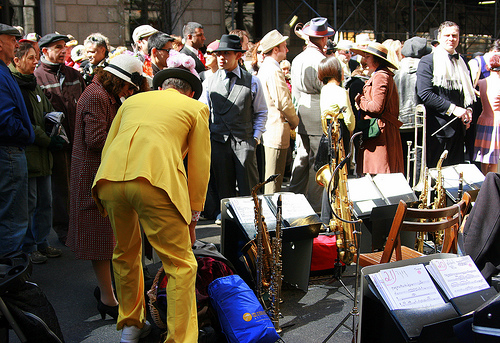

In [ ]:
import random
test_im = 'Flickr8k_Dataset/Flicker8k_Dataset/' # path of image
list_addresses = list(encoding_test.keys())
test_im =test_im+list_addresses[random.randint(1,len(encoding_test.keys()))]

print(predict_captions(test_im))
Image.open(test_im)


In [ ]:
final_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 40)]                 0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 40, 300)              2476800   ['input_5[0][0]']             
                                                                                                  
 dense_3 (Dense)             (None, 300)                  614700    ['input_4[0][0]']             
                                                                                            

Now try your predict function and see the results :)

1/1 [==============================] - 0s 22ms/step
Two girls with colorful hair are looking at the camera .


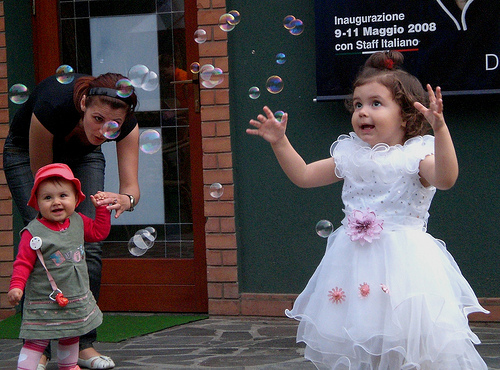

In [ ]:
import random
test_im = 'Flickr8k_Dataset/Flicker8k_Dataset/' # path of image
list_addresses = list(encoding_test.keys())
test_im =test_im+list_addresses[random.randint(1,len(encoding_test.keys()))]

print(predict_captions(test_im))
Image.open(test_im)


In [ ]:
from google.colab import files
files.download("/content/time_inceptionV3_7_loss_idk_V2.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
test_im

'Flickr8k_Dataset/Flicker8k_Dataset/498794783_cc2ac62b47.jpg'